## Setup and Imports
This section includes all necessary imports and initial setup for PyTorch, torchvision, and utility libraries. It also ensures reproducibility by setting random seeds.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import zipfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [4]:
import json, pathlib, requests, os, torch, torchvision, numpy as np
from torchvision import transforms
from torchvision.models import ResNet34_Weights
import requests

In [5]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Device Configuration
Here, we detect and set the appropriate computation device (GPU if available, else CPU).


In [6]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Task 1: Custom Dataset Preparation
This section defines a custom PyTorch `Dataset` class for handling a structured subset of the ImageNet dataset. Images are loaded, transformed, and labeled based on their class folders.


In [7]:
# ----- TASK 1: BASICS -----

class ImageNetSubsetDataset(Dataset):
    """Custom Dataset for a structured subset of ImageNet"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing class-specific folders of images.
            transform (callable, optional): Optional image transformation to apply.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Identify all subfolders (each folder represents a separate class)
        self.classes = [folder for folder in os.listdir(root_dir)
                        if os.path.isdir(os.path.join(root_dir, folder))]

        # Map each class name to a unique integer label
        self.class_to_idx = {name: idx for idx, name in enumerate(self.classes)}

        # Prepare a list of (image_path, class_label) tuples
        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_path):
                # Include only common image formats
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, file_name)
                    label = self.class_to_idx[class_name]
                    self.samples.append((image_path, label))

        # Logging number of classes and images discovered
        print(f"Detected {len(self.classes)} class folders")
        print(f"Collected {len(self.samples)} image samples")

    def __len__(self):
        """
        Returns:
            int: Total number of image samples in the dataset
        """
        return len(self.samples)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the item to retrieve

        Returns:
            tuple: (transformed_image, label)
        """
        img_path, label = self.samples[index]
        try:
            # Load image and convert to RGB format
            image = Image.open(img_path).convert('RGB')

            # Apply transformations if provided
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as error:
            # Handle corrupted or unreadable images by returning a blank tensor
            print(f"Failed to load image {img_path}: {error}")
            fallback = torch.zeros(3, 224, 224) if self.transform else torch.zeros(3, 32, 32)
            return fallback, label


## Data Transformations
Here we define data transformations such as resizing, normalization, and tensor conversion using `torchvision.transforms.Compose` for preprocessing the images.


In [8]:

def load_model_and_data(dataset_path="/kaggle/input/testdataset/TestDataSet"):
    """
    Loads the pretrained ResNet-34 model along with a folder-structured subset of ImageNet.
    Also handles normalization setup, label remapping, and human-readable label mapping.

    Returns:
        model: Pretrained ResNet-34 model
        loader: DataLoader for the dataset
        dataset: ImageFolder dataset with remapped labels
        class_names: Dictionary mapping class indices to human-readable labels
        mean: Normalization mean
        std: Normalization std
        IM_LOW: Lower bound tensor for adversarial clamping
        IM_HIGH: Upper bound tensor for adversarial clamping
    """

    # ─── 1. Load Pretrained ResNet-34 ───────────────────────────────────────
    print("🔄 Loading pretrained ResNet‑34 …")
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = torchvision.models.resnet34(weights=weights).to(device).eval()

    # ─── 2. Define Normalization Parameters and Clamp Bounds ───────────────
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    mean_t = torch.tensor(mean, device=device)
    std_t  = torch.tensor(std,  device=device)

    global IM_LOW, IM_HIGH
    IM_LOW  = ((0.0 - mean_t) / std_t).view(3, 1, 1)  # clamp lower bound
    IM_HIGH = ((1.0 - mean_t) / std_t).view(3, 1, 1)  # clamp upper bound

    # ─── 3. Compose Transformations (Resize → CenterCrop → Normalize) ─────
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # ─── 4. Load ImageNet-style Folder Dataset ─────────────────────────────
    nested = os.path.join(dataset_path, "TestDataSet")
    root = nested if os.path.isdir(nested) else dataset_path
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
    print(f"✔️  Loaded {len(dataset)} images across {len(dataset.classes)} class folders")

    # ─── 5. Download Official ImageNet Index (if missing) ─────────────────
    idx_file = "/kaggle/working/imagenet_class_index.json"
    if not os.path.isfile(idx_file):
        print("📥 Downloading ImageNet index …")
        url = ("https://s3.amazonaws.com/deep-learning-models/"
               "image-models/imagenet_class_index.json")
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        with open(idx_file, "wb") as f:
            f.write(r.content)

    # ─── 6. Remap Dataset Labels to Official ImageNet Index ───────────────
    with open(idx_file) as f:
        full_index = json.load(f)  # { "0": ["n01440764", "tench"], ... }

    synset_to_idx = {v[0]: int(k) for k, v in full_index.items()}
    subset2imagenet = {syn: synset_to_idx[syn] for syn in dataset.classes}
    dataset.class_to_idx = subset2imagenet

    # Remap sample targets using ImageNet indices
    new_samples = []
    for img_path, _ in dataset.samples:
        synset = os.path.basename(os.path.dirname(img_path))
        new_samples.append((img_path, subset2imagenet[synset]))

    dataset.samples = new_samples
    dataset.imgs = new_samples         # alias used by ImageFolder
    dataset.targets = [t for _, t in new_samples]

    # ─── 7. Load Human-Readable Label File ────────────────────────────────
    labels_file = os.path.join(root, "labels_list.json")
    if not os.path.isfile(labels_file):
        raise FileNotFoundError("Missing labels_list.json in TestDataSet")

    with open(labels_file) as f:
        label_lines = json.load(f)  # ["0: tench", "1: goldfish", ...]

    idx2human = {
        int(line.split(":", 1)[0].strip()): line.split(":", 1)[1].strip()
        for line in label_lines
    }

    # ─── 8. Construct Final Class Index → Human Label Mapping ─────────────
    class_names = {}
    for syn, idx in subset2imagenet.items():
        class_names[idx] = idx2human.get(idx, full_index[str(idx)][1])

    # ─── 9. Create DataLoader for Inference ───────────────────────────────
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return model, loader, dataset, class_names, mean, std, IM_LOW, IM_HIGH


In [9]:
model, loader, ds, cls_names, mean, std, IM_LOW, IM_HIGH = load_model_and_data()

🔄 Loading pretrained ResNet‑34 …


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 160MB/s] 


✔️  Loaded 500 images across 100 class folders
📥 Downloading ImageNet index …


In [10]:
GLOBAL_STD_T = torch.tensor(std, device=device).view(3,1,1)

## Evaluation Logic
This section defines evaluation functions to measure model performance using metrics like accuracy and loss.


In [11]:
def evaluate_model(model, dataloader, device='cuda'):
    """
    Evaluates a trained PyTorch model on a given dataset.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (DataLoader): DataLoader for the evaluation dataset.
        device (str): Device on which to perform the evaluation ('cuda' or 'cpu').

    Returns:
        top1_acc (float): Top-1 classification accuracy in percentage.
        top5_acc (float): Top-5 classification accuracy in percentage.
        all_images (Tensor): Concatenated tensor of all input images.
        all_labels (Tensor): Concatenated tensor of all corresponding ground-truth labels.
    """
    model.eval()  # Set model to evaluation mode

    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0
    all_images = []
    all_labels = []

    # No need to compute gradients during evaluation
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating model"):
            # Move input tensors to the target device
            images = images.to(device).float()
            labels = labels.to(device)

            # Store inputs and labels for later analysis or visualization
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())

            # Forward pass through the model
            outputs = model(images)

            # Top-1 prediction
            _, top1_pred = outputs.max(dim=1)
            correct_top1 += (top1_pred == labels).sum().item()

            # Top-5 prediction
            _, top5_preds = outputs.topk(5, dim=1)
            for i in range(labels.size(0)):
                if labels[i] in top5_preds[i]:
                    correct_top5 += 1

            total_samples += labels.size(0)

    # Compute accuracy percentages
    top1_acc = 100 * correct_top1 / total_samples
    top5_acc = 100 * correct_top5 / total_samples

    # Aggregate all evaluation images and labels
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Print evaluation results
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")
    print(f"Total samples evaluated: {total_samples}")

    return top1_acc, top5_acc, all_images, all_labels



In [12]:
def evaluate_tta(model, dataloader, device='cuda'):
    """
    Evaluates a model using Test-Time Augmentation (TTA), where multiple augmented versions
    of each image are averaged to improve prediction stability.

    Args:
        model (nn.Module): The trained model to evaluate.
        dataloader (DataLoader): Dataloader that yields batches with TTA applied 
                                 (shape: [batch_size, num_augmentations, 3, 224, 224]).
        device (str): Device to use for computation ('cuda' or 'cpu').

    Returns:
        tta_top1 (float): Top-1 accuracy using TTA, in percentage.
        tta_top5 (float): Top-5 accuracy using TTA, in percentage.
    """
    model.eval()  # Set model to evaluation mode
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0

    with torch.no_grad():
        for tta_imgs, labels in tqdm(dataloader, desc="TTA Eval"):
            # tta_imgs shape: [batch_size, num_augmentations, 3, 224, 224]
            batch_size, num_augs, channels, height, width = tta_imgs.shape

            # Flatten TTA batch: [batch_size * num_augs, 3, 224, 224]
            tta_imgs = tta_imgs.view(-1, channels, height, width).to(device)

            # Run model on all augmentations
            logits = model(tta_imgs)  # shape: [batch_size * num_augs, num_classes]

            # Reshape and average over augmentations: [batch_size, num_classes]
            logits = logits.view(batch_size, num_augs, -1).mean(dim=1)

            # Compute Top-1 predictions
            _, top1_pred = logits.max(dim=1)
            correct_top1 += (top1_pred.cpu() == labels).sum().item()

            # Compute Top-5 predictions
            _, top5_preds = logits.topk(5, dim=1)
            for i in range(batch_size):
                if labels[i] in top5_preds[i].cpu():
                    correct_top5 += 1

            total_samples += batch_size

    # Calculate TTA-based accuracies
    tta_top1 = 100 * correct_top1 / total_samples
    tta_top5 = 100 * correct_top5 / total_samples

    print(f"TTA Top‑1 Accuracy: {tta_top1:.2f}%")
    print(f"TTA Top‑5 Accuracy: {tta_top5:.2f}%")

    return tta_top1, tta_top5


In [13]:
top1, top5, all_images, all_labels = evaluate_model(model, loader, device=device)


Evaluating model: 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%
Total samples evaluated: 500


In [14]:
def get_predictions(model, images, device='cuda'):
    """
    Generates top-1 and top-5 predictions for a given batch of images using a trained model.

    Args:
        model (nn.Module): Trained PyTorch model for inference.
        images (Tensor): Batch of input images (shape: [batch_size, 3, H, W]).
        device (str): Target device for computation ('cuda' or 'cpu').

    Returns:
        top1_preds (Tensor): Top-1 predicted class indices for each image.
        top5_preds (Tensor): Top-5 predicted class indices for each image.
        probs (Tensor): Softmax probabilities for each class.
    """
    model.eval()  # Set model to inference mode

    # Move images to the specified device
    images = images.to(device)

    with torch.no_grad():  # Disable gradient tracking for efficiency
        # Forward pass
        logits = model(images)

        # Convert logits to probabilities using softmax
        probs = torch.nn.functional.softmax(logits, dim=1)

        # Extract top-1 predictions
        _, top1_preds = logits.max(dim=1)

        # Extract top-5 predictions
        _, top5_preds = logits.topk(5, dim=1)

    # Return all outputs moved to CPU
    return top1_preds.cpu(), top5_preds.cpu(), probs.cpu()


In [15]:
def denormalize(tensor, mean_norms, std_norms):
    """
    Reverts normalization for a batch of image tensors using broadcasting.

    Args:
        tensor (Tensor): Normalized image tensor of shape [N, 3, H, W]
        mean_norms (list or tuple): Mean values used for normalization
        std_norms (list or tuple): Std values used for normalization

    Returns:
        Tensor: Denormalized tensor in range [0, 1]
    """
    tensor = tensor.clone().detach().cpu()

    # Convert mean and std to tensors for broadcasting
    mean = torch.tensor(mean_norms).view(1, -1, 1, 1)
    std = torch.tensor(std_norms).view(1, -1, 1, 1)

    # Apply inverse normalization in one step using broadcasting
    tensor = tensor * std + mean

    return torch.clamp(tensor, 0, 1)


In [16]:
def visualize_predictions(model, images, labels, class_names, mean_norms, std_norms, num_samples=5):
    """
    Randomly selects a subset of images and visualizes the model's top-1 and top-5 predictions.

    Args:
        model (nn.Module): Trained PyTorch model to generate predictions.
        images (Tensor): Batch of input images (normalized).
        labels (Tensor): Ground-truth labels for the images.
        class_names (dict): Mapping from class index to human-readable class names.
        mean_norms (list): Mean used for image normalization.
        std_norms (list): Std used for image normalization.
        num_samples (int): Number of images to visualize.
    """
    # Randomly sample image indices from the dataset
    indices = np.random.choice(len(images), size=num_samples, replace=False)

    # Select corresponding image and label samples
    sample_images = torch.stack([images[i] for i in indices])
    sample_labels = torch.stack([labels[i] for i in indices])

    # Run inference to get predictions
    top1_preds, top5_preds, probs = get_predictions(model, sample_images)

    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i in range(num_samples):
        image = sample_images[i]
        true_label = sample_labels[i].item()
        predicted_label = top1_preds[i].item()

        # Lookup class names from indices
        true_class = class_names.get(true_label, f"Unknown ({true_label})")
        pred_class = class_names.get(predicted_label, f"Unknown ({predicted_label})")

        # Format top-5 predicted class names with probabilities
        top5_info = []
        for j in range(5):
            class_idx = top5_preds[i][j].item()
            class_name = class_names.get(class_idx, f"Unknown ({class_idx})")
            confidence = probs[i][class_idx].item() * 100
            top5_info.append(f"{class_name}: {confidence:.2f}%")

        # Convert image from normalized to displayable format
        img_to_show = denormalize(image.unsqueeze(0), mean_norms, std_norms)[0]
        axes[i].imshow(img_to_show.permute(1, 2, 0))

        # Compose the plot title
        title = f"True: {true_class} | Predicted: {pred_class}"
        title += " (Correct)" if predicted_label == true_label else " (Incorrect)"
        axes[i].set_title(title)

        # Display top-5 predictions alongside image
        text_info = "\n".join(top5_info)
        axes[i].text(1.05, 0.5, text_info, transform=axes[i].transAxes, 
                     verticalalignment='center', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Adversarial Attacks (FGSM / PGD)
This part implements adversarial attack methods (e.g., FGSM, PGD) to test model robustness against perturbed inputs.


In [99]:
# ----- TASK 2: FGSM ATTACK -----

def fgsm_attack(model, images, labels, epsilon=0.02, device='cuda'):
    """
    Performs a one-step Fast Gradient Sign Method (FGSM) adversarial attack.

    The attack perturbs the input images in the direction of the gradient of the loss
    with respect to the input, scaled by a small epsilon. The perturbation is applied
    in the normalized image space.

    Args:
        model (nn.Module): The target model to attack.
        images (Tensor): Batch of input images (normalized).
        labels (Tensor): Ground truth labels for the images.
        epsilon (float): Maximum perturbation magnitude in raw [0,1] space.
        device (str): Device to perform computation on.

    Returns:
        Tensor: Adversarially perturbed images (still normalized).
    """
    # Move inputs to target device
    images = images.to(device)
    labels = labels.to(device)

    # Clone and enable gradient tracking on the input
    x = images.clone().detach().requires_grad_(True)

    # Forward pass and compute loss
    outputs = model(x)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Backward pass to compute gradients w.r.t input
    model.zero_grad()
    loss.backward()

    # Normalize epsilon to match input space (channel-wise std)
    eps_norm = epsilon / GLOBAL_STD_T  # GLOBAL_STD_T must be [3×1×1]

    # Perform FGSM step: move input in direction of sign of gradient
    perturbation = eps_norm * x.grad.sign()
    x_adv = x + perturbation

    # Clamp to valid normalized bounds
    x_adv = torch.clamp(x_adv, IM_LOW, IM_HIGH)

    return x_adv.detach()


In [100]:
import math

def create_adversarial_dataset(model, original_images, original_labels,
                                attack_fn, epsilon=0.02, batch_size=32, device='cuda'):
    """
    Generates adversarial examples for an entire dataset using a given attack method.

    Args:
        model (nn.Module): PyTorch model to attack.
        original_images (Tensor): Input images (normalized).
        original_labels (Tensor): Corresponding ground-truth labels.
        attack_fn (Callable): Adversarial attack function (e.g., FGSM).
        epsilon (float): Perturbation budget for the attack.
        batch_size (int): Batch size for processing to avoid OOM errors.
        device (str): Device to perform computation on ('cuda' or 'cpu').

    Returns:
        Tensor: Complete tensor of adversarial images (same shape as original_images).
    """
    model.eval()  # Ensure model is in evaluation mode
    adv_images = []  # Store adversarial batches here

    # Calculate number of batches (ceil division)
    num_batches = math.ceil(len(original_images) / batch_size)

    for i in tqdm(range(num_batches), desc=f"Creating adversarial examples (ε={epsilon})"):
        # Slice batch from dataset
        start = i * batch_size
        end = min((i + 1) * batch_size, len(original_images))

        batch_imgs = original_images[start:end]
        batch_lbls = original_labels[start:end]

        # Generate adversarial examples for the batch
        adv_batch = attack_fn(model, batch_imgs, batch_lbls, epsilon=epsilon, device=device)

        # Move to CPU and store
        adv_images.append(adv_batch.cpu())

    # Concatenate all adversarial batches into a single tensor
    adv_images = torch.cat(adv_images).float()

    return adv_images


In [101]:
def compute_l_inf_distance(original_images, perturbed_images):
    """
    Computes the L∞ (max-norm) distance between original and adversarial images.

    The L∞ distance measures the largest absolute pixel-wise difference
    between the original and perturbed image tensors for each sample.

    Args:
        original_images (Tensor): Tensor of original input images.
        perturbed_images (Tensor): Corresponding adversarial images.

    Returns:
        Tensor: L∞ distance for each image in the batch (shape: [batch_size]).
    """
    # Calculate element-wise absolute difference
    abs_diff = torch.abs(original_images - perturbed_images)

    # Flatten each image and get the maximum absolute difference (L∞ norm)
    l_inf_per_image = abs_diff.view(abs_diff.size(0), -1).max(dim=1)[0]

    return l_inf_per_image


In [109]:
def visualize_adversarial_examples(model, original_images, adversarial_images,
                                   original_labels, class_names, mean_norms, std_norms, num_samples=5,):
    """
    Visualizes original vs. adversarial images along with model predictions and perturbation heatmaps.

    Args:
        model (nn.Module): The trained model for evaluation.
        original_images (Tensor): Batch of original (clean) images.
        adversarial_images (Tensor): Corresponding adversarially perturbed images.
        original_labels (Tensor): Ground truth labels.
        class_names (dict): Mapping from class index to readable class name.
        mean_norms (list): Normalization mean used during preprocessing.
        std_norms (list): Normalization std used during preprocessing.
        num_samples (int): Number of samples to visualize.
    """
    # Get top-1 predictions on clean and adversarial images
    orig_preds, _, orig_probs = get_predictions(model, original_images)
    adv_preds, _, adv_probs = get_predictions(model, adversarial_images)

    # Identify which predictions changed (i.e., successful adversarial attacks)
    fooled_mask = (orig_preds != adv_preds).nonzero(as_tuple=True)[0]

    # If there are successful attacks, sample from those; else, choose randomly
    if len(fooled_mask) > 0:
        selected_indices = np.random.choice(fooled_mask.cpu().numpy(),
                                            size=min(num_samples, len(fooled_mask)),
                                            replace=False)
    else:
        selected_indices = np.random.choice(len(original_images),
                                            size=min(num_samples, len(original_images)),
                                            replace=False)

    # Gather selected original and adversarial images and labels
    sample_orig = torch.stack([original_images[i] for i in selected_indices])
    sample_adv = torch.stack([adversarial_images[i] for i in selected_indices])
    sample_labels = torch.stack([original_labels[i] for i in selected_indices])

    # Recompute predictions for selected samples
    orig_preds, _, orig_probs = get_predictions(model, sample_orig)
    adv_preds, _, adv_probs = get_predictions(model, sample_adv)

    # Set up plot grid (1 row per sample: original, adversarial, perturbation)
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure it's iterable

    for i in range(len(selected_indices)):
        orig_img = sample_orig[i]
        adv_img = sample_adv[i]
        diff_img = adv_img - orig_img  # Pixel-wise perturbation
        true_idx = sample_labels[i].item()
        pred_orig = orig_preds[i].item()
        pred_adv = adv_preds[i].item()

        # Get class names and prediction confidences
        true_class = class_names.get(true_idx, f"Unknown ({true_idx})")
        class_orig = class_names.get(pred_orig, f"Unknown ({pred_orig})")
        class_adv = class_names.get(pred_adv, f"Unknown ({pred_adv})")
        conf_orig = orig_probs[i][pred_orig].item() * 100
        conf_adv = adv_probs[i][pred_adv].item() * 100

        # Plot original image
        axes[i][0].imshow(denormalize(orig_img.unsqueeze(0), mean_norms, std_norms)[0].permute(1, 2, 0))
        axes[i][0].set_title(f"Original\nTrue: {true_class}\nPred: {class_orig} ({conf_orig:.2f}%)")
        axes[i][0].axis('off')

        # Plot adversarial image
        axes[i][1].imshow(denormalize(adv_img.unsqueeze(0), mean_norms, std_norms)[0].permute(1, 2, 0))
        axes[i][1].set_title(f"Adversarial\nTrue: {true_class}\nPred: {class_adv} ({conf_adv:.2f}%)")
        axes[i][1].axis('off')

        # Plot perturbation heatmap (scaled abs diff, averaged over channels)
        perturbation_map = diff_img.abs().mean(dim=0)
        diff_img = denormalize(diff_img.unsqueeze(0), mean_norms, std_norms)[0].permute(1, 2, 0)
        l_inf_val = diff_img.abs().max().item()
        axes[i][2].imshow(perturbation_map.cpu(), cmap='hot')
        axes[i][2].set_title(f"Perturbation\nL∞ distance: {l_inf_val:.4f}")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()


In [110]:
def save_adversarial_dataset(adversarial_images, dataset_path, filename):
    """
    Saves the adversarial image tensor to disk for reuse or evaluation.

    Args:
        adversarial_images (Tensor): The generated adversarial examples to be saved.
        dataset_path (str): Directory where the file will be stored.
        filename (str): Name of the file to store the tensor (e.g., "adv_data.pt").
    """
    # Ensure the target directory exists
    os.makedirs(dataset_path, exist_ok=True)

    # Construct the full file path
    full_path = os.path.join(dataset_path, filename)

    # Save the tensor using PyTorch's built-in serialization
    torch.save(adversarial_images, full_path)

    print(f" Adversarial dataset saved to: {full_path}")


In [111]:
# === Task 1: Baseline Evaluation ===
def execute_task_1(dataset_path="/kaggle/input/testdataset/TestDataSet"):
    """
    Performs baseline evaluation using a pretrained ResNet‑34 model on clean test data.

    Steps:
    1. Loads the dataset and pretrained model.
    2. Evaluates the model on clean (unaltered) images.
    3. Prints Top-1 and Top-5 accuracy.
    4. Visualizes a few prediction results.

    Args:
        dataset_path (str): Path to the test dataset directory.

    Returns:
        Tuple containing:
            - model (nn.Module): Loaded ResNet-34 model
            - all_images (Tensor): All input images from the test set
            - all_labels (Tensor): Corresponding labels
            - class_names (dict): Mapping from index to class name
            - mean_norms (list): Normalization means used during preprocessing
            - std_norms (list): Normalization stds used during preprocessing
            - top1_acc (float): Top-1 classification accuracy on clean set
            - top5_acc (float): Top-5 classification accuracy on clean set
    """
    # Step 1: Load model and test data
    model, dataloader, dataset, class_names, mean_norms, std_norms, IM_LOW, IM_HIGH = \
        load_model_and_data(dataset_path)

    print("=== Task 1: Basics — Baseline Evaluation ===")

    # Step 2: Evaluate on clean test set
    top1_acc, top5_acc, all_images, all_labels = evaluate_model(
        model, dataloader, device=device
    )

    # Step 3: Visualize a few predictions (correct or incorrect)
    visualize_predictions(
        model=model,
        images=all_images,
        labels=all_labels,
        class_names=class_names,
        mean_norms=mean_norms,
        std_norms=std_norms,
        num_samples=5
    )

    # Step 4: Return key results for use in future tasks
    return model, all_images, all_labels, class_names, mean_norms, std_norms, top1_acc, top5_acc


🔄 Loading pretrained ResNet‑34 …
✔️  Loaded 500 images across 100 class folders
=== Task 1: Basics — Baseline Evaluation ===


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  9.38it/s]


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%
Total samples evaluated: 500


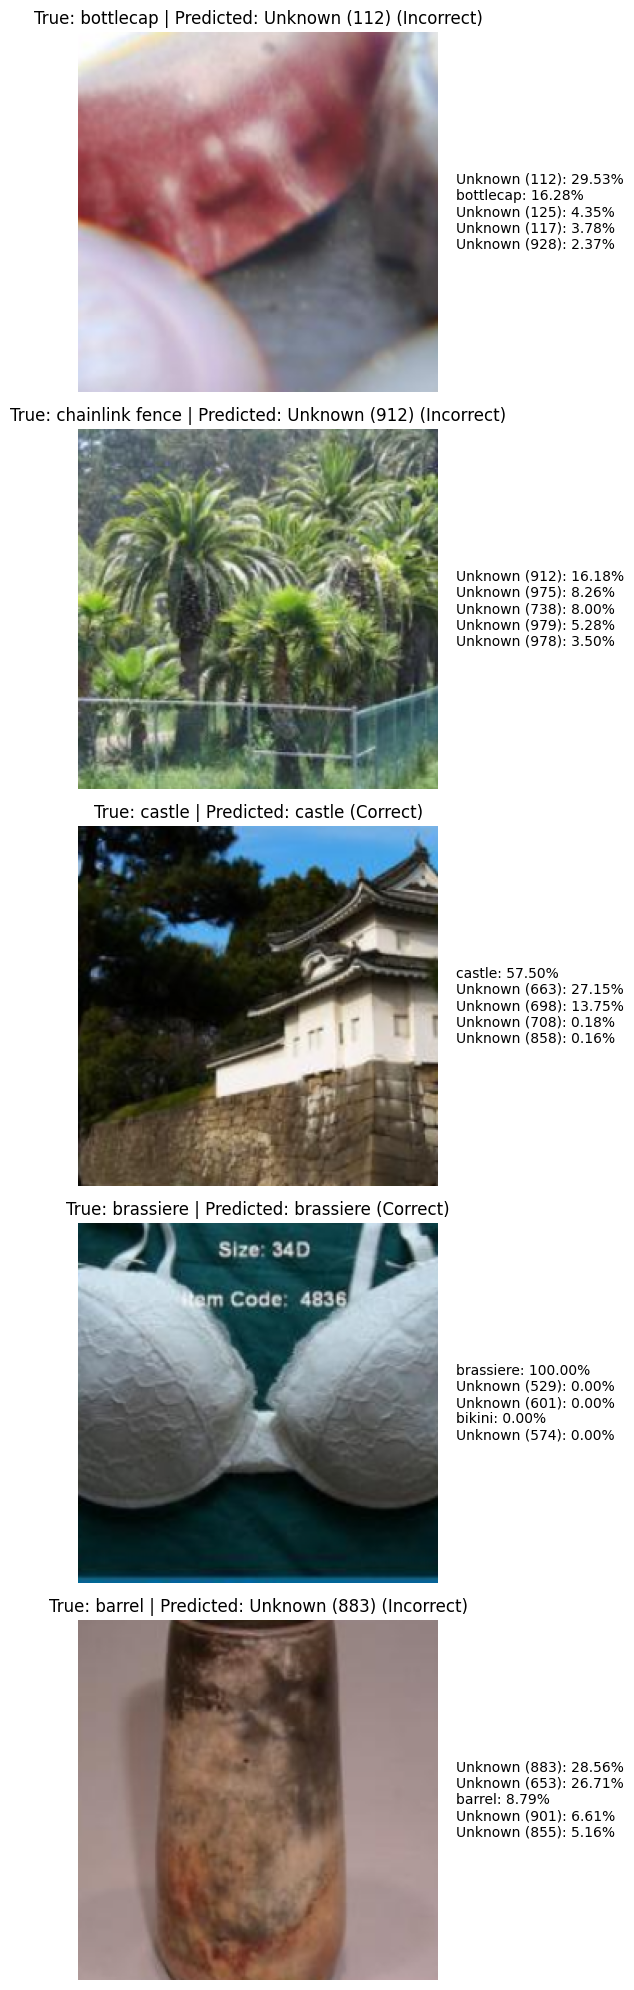

In [112]:
# Run Task 1
model, images, labels, cls_names, mean, std, base1, base5 = execute_task_1()

In [113]:
# === Task 2: FGSM Attack ===
def execute_task_2(
    model,
    orig_images,
    orig_labels,
    class_names,
    mean_norms,
    std_norms,
    top1_acc,
    top5_acc,
    epsilon=0.02
):
    """
    Executes an FGSM adversarial attack on a dataset and evaluates its impact.

    Steps:
    1. Generates adversarial examples using FGSM.
    2. Verifies L∞ distance constraint.
    3. Saves the adversarial dataset to disk.
    4. Evaluates model performance on adversarial data.
    5. Prints accuracy drops and visualizes attack results.

    Args:
        model (nn.Module): Pretrained model to attack.
        orig_images (Tensor): Original input images.
        orig_labels (Tensor): Ground-truth labels.
        class_names (dict): Mapping from label indices to class names.
        mean_norms (list): Normalization means used during preprocessing.
        std_norms (list): Normalization stds used during preprocessing.
        top1_acc (float): Baseline Top-1 accuracy on clean images.
        top5_acc (float): Baseline Top-5 accuracy on clean images.
        epsilon (float): Perturbation strength for FGSM attack.

    Returns:
        Tensor: Adversarial image set.
    """
    print("=== Task 2: FGSM Attack ===")

    # Step 1: Generate adversarial examples using FGSM
    adv_images = create_adversarial_dataset(
        model=model,
        original_images=orig_images,
        original_labels=orig_labels,
        attack_fn=fgsm_attack,
        epsilon=epsilon,
        batch_size=32,
        device=device
    )
    orig_raw = denormalize(orig_images, mean_norms, std_norms)  # shape [B,3,H,W], values in [0,1]
    adv_raw  = denormalize(adv_images,  mean_norms, std_norms)
    # Step 2: Check the L∞ distance constraint for safety validation
    # l_inf_distances = compute_l_inf_distance(orig_images, adv_images).max().item()
    l_inf_distances = compute_l_inf_distance(orig_raw, adv_raw)
    print(f"Maximum L∞ distance: {l_inf_distances.max().item():.6f} (≤ {epsilon})")

    # Step 3: Save the generated adversarial dataset to disk
    save_adversarial_dataset(
        adversarial_images=adv_images,
        dataset_path="/kaggle/working",
        filename="adversarial_test_set_1.pt"
    )


    # Step 4: Evaluate model on the adversarial data
    adv_dataset = torch.utils.data.TensorDataset(adv_images, orig_labels)
    adv_loader = torch.utils.data.DataLoader(
        adv_dataset,
        batch_size=32,
        shuffle=False
    )
    adv_top1, adv_top5, _, _ = evaluate_model(
        model=model,
        dataloader=adv_loader,
        device=device
    )

    # Step 5: Report accuracy drop due to attack
    print(f"Top-1 drop: {top1_acc - adv_top1:.2f}% (from {top1_acc:.2f}% → {adv_top1:.2f}%)")
    print(f"Top-5 drop: {top5_acc - adv_top5:.2f}% (from {top5_acc:.2f}% → {adv_top5:.2f}%)")

    # Step 6: Visualize adversarial examples vs originals
    visualize_adversarial_examples(
        model=model,
        original_images=orig_images,
        adversarial_images=adv_images,
        original_labels=orig_labels,
        class_names=class_names,
        mean_norms=mean_norms,
        std_norms=std_norms,
        num_samples=5,
    )

    return adv_images


=== Task 2: FGSM Attack ===


Creating adversarial examples (ε=0.02): 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]


Maximum L∞ distance: 0.020000 (≤ 0.02)
 Adversarial dataset saved to: /kaggle/working/adversarial_test_set_1.pt


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 16.05it/s]


Top-1 Accuracy: 3.00%
Top-5 Accuracy: 19.00%
Total samples evaluated: 500
Top-1 drop: 67.40% (from 70.40% → 3.00%)
Top-5 drop: 74.20% (from 93.20% → 19.00%)


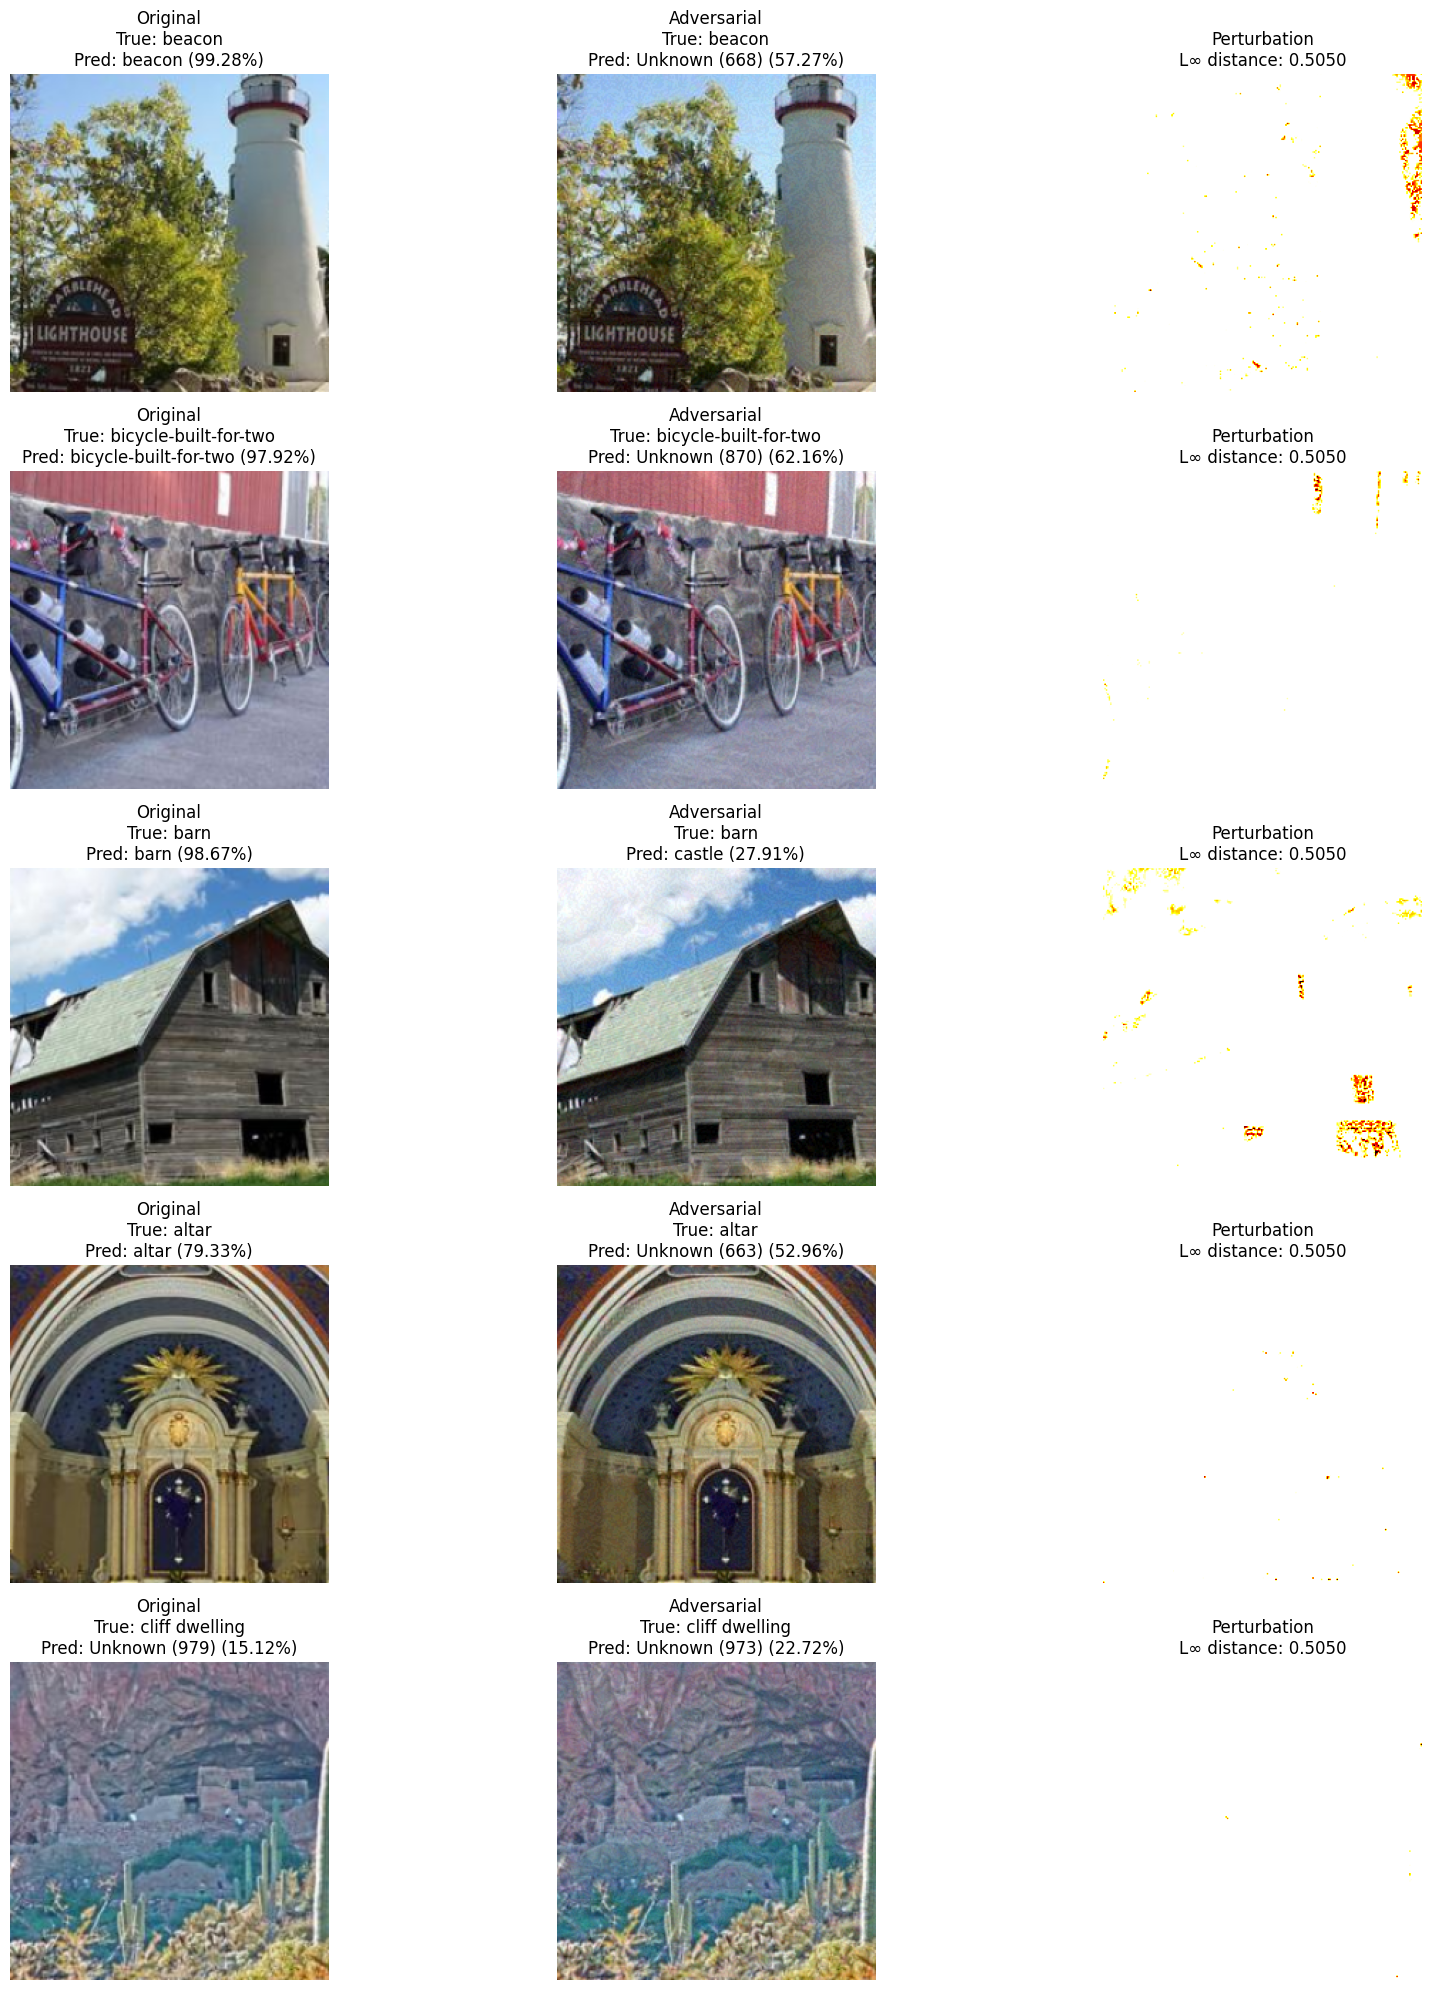

In [114]:
# Run Task 2
adv1 = execute_task_2(model, images, labels, cls_names, mean, std, base1, base5)

In [82]:
# ----- TASK 3: IMPROVED ATTACKS -----

def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.01, num_iter=10, device='cuda'):
    """
    Performs the Projected Gradient Descent (PGD) adversarial attack.

    PGD is an iterative attack that applies multiple FGSM-like steps, followed
    by projection back into the allowed L∞ epsilon-ball around the original input.
    It is widely considered a strong first-order adversary.

    Args:
        model (nn.Module): Model to be attacked.
        images (Tensor): Input images (normalized).
        labels (Tensor): True class labels for the images.
        epsilon (float): Max allowed perturbation (L∞ bound).
        alpha (float): Step size per iteration.
        num_iter (int): Total number of attack iterations.
        device (str): Device to run computation on ('cuda' or 'cpu').

    Returns:
        Tensor: Final adversarial examples.
    """
    # Move data to the specified device
    images = images.to(device)
    labels = labels.to(device)

    # Initialize perturbed images as a detached clone
    adv_images = images.clone().detach()

    for _ in range(num_iter):
        # Ensure gradients are not accumulated from previous iterations
        if adv_images.grad is not None:
            adv_images.grad.zero_()

        # Enable gradient tracking
        adv_images.requires_grad_(True)

        # Forward pass and loss computation
        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        # Backward pass to compute gradients
        model.zero_grad()
        loss.backward()

        # Gradient w.r.t input
        grad_sign = adv_images.grad.sign()

        # Take a small step in direction of gradient
        with torch.no_grad():
            adv_images = adv_images + alpha * grad_sign

            # Project the perturbation onto the epsilon-ball around the original input
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = images + delta

            # Clamp to valid normalized pixel bounds
            adv_images = torch.clamp(adv_images, IM_LOW, IM_HIGH)

    # Final cleanup
    adv_images.requires_grad_(False)
    return adv_images.detach()


In [83]:
# ---------------------------------------------------------------------
# Momentum PGD (M-PGD): A stronger iterative Linf adversarial attack
# - epsilon  : Max Linf perturbation (ε-ball constraint)
# - alpha    : Step size per iteration
# - num_iter : Number of gradient steps
# - mu       : Momentum decay factor (commonly set to 0.9)
# ---------------------------------------------------------------------
def momentum_pgd_attack(model,
                        images,
                        labels,
                        epsilon=0.02,
                        alpha=0.01,
                        num_iter=10,
                        mu=0.9,
                        device='cuda'):
    """
    Performs Momentum Iterative FGSM (MI-FGSM), an enhanced PGD attack with momentum
    to stabilize and strengthen adversarial perturbations.

    Reference:
        Dong et al., "Boosting Adversarial Attacks with Momentum", CVPR 2018.

    Args:
        model (nn.Module): Target model to attack.
        images (Tensor): Input images (normalized).
        labels (Tensor): Corresponding ground-truth labels.
        epsilon (float): L∞-norm constraint (maximum perturbation).
        alpha (float): Step size for each iteration (should be ≤ epsilon).
        num_iter (int): Number of gradient ascent steps.
        mu (float): Momentum factor to accumulate gradients.
        device (str): Device to use for computation ('cuda' or 'cpu').

    Returns:
        Tensor: Final adversarial images after applying momentum PGD.
    """
    # Move inputs to the correct device and initialize perturbed images
    images = images.to(device)
    labels = labels.to(device)
    x_adv = images.clone().detach()

    # Initialize momentum buffer (same shape as input)
    momentum = torch.zeros_like(images)

    for _ in range(num_iter):
        # Clear previous gradients
        if x_adv.grad is not None:
            x_adv.grad.zero_()

        # Enable gradient tracking
        x_adv.requires_grad_(True)

        # Forward and compute loss
        logits = model(x_adv)
        loss = torch.nn.functional.cross_entropy(logits, labels)

        # Backward pass to compute gradient w.r.t input
        model.zero_grad()
        loss.backward()

        # Normalize gradients by L1 norm per sample and update momentum
        grad = x_adv.grad.detach()
        grad_norm = grad.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8
        normalized_grad = grad / grad_norm
        momentum = mu * momentum + normalized_grad  # Momentum accumulation

        # Apply gradient step using sign of momentum
        x_adv = x_adv + alpha * momentum.sign()

        # Project perturbation back to epsilon-ball
        delta = torch.clamp(x_adv - images, min=-epsilon, max=epsilon)
        x_adv = images + delta

        # Clamp to valid normalized image range
        x_adv = torch.clamp(x_adv, min=IM_LOW, max=IM_HIGH)

        # Detach to avoid gradient history across iterations
        x_adv = x_adv.detach()

    return x_adv


In [84]:
def targeted_pgd_attack(model,
                        images,
                        labels,
                        epsilon=0.02,
                        alpha=0.01,
                        num_iter=10,
                        device='cuda',
                        target_method='least_likely'):
    """
    Performs a targeted PGD attack, where the adversarial perturbation is designed
    to push predictions toward a specific target class rather than simply causing misclassification.

    Args:
        model (nn.Module): The model to attack.
        images (Tensor): Batch of original input images (normalized).
        labels (Tensor): Ground-truth labels for the inputs.
        epsilon (float): Maximum allowed perturbation (L∞ constraint).
        alpha (float): Step size per iteration.
        num_iter (int): Number of attack iterations.
        device (str): Device to run the attack on ('cuda' or 'cpu').
        target_method (str): How to choose the target class:
            - 'least_likely': class with minimum model confidence
            - 'random': a randomly selected class not equal to true label

    Returns:
        Tensor: Targeted adversarial examples (shape matches input images).
    """
    # Move inputs to the correct device
    images = images.to(device)
    labels = labels.to(device)

    # Step 1: Select target class for each input
    with torch.no_grad():
        logits = model(images)

        if target_method == 'least_likely':
            # Target class = class with lowest predicted probability
            _, target_labels = logits.min(dim=1)

        elif target_method == 'random':
            # Random class different from the true label
            num_classes = logits.shape[1]
            target_labels = torch.randint(0, num_classes, labels.shape, device=device)
            for i in range(len(labels)):
                while target_labels[i] == labels[i]:
                    target_labels[i] = torch.randint(0, num_classes, (1,), device=device)

        else:
            raise ValueError(f"Unknown target method: {target_method}")

    # Step 2: Initialize adversarial image as a detached copy of the original
    adv_images = images.clone().detach()

    for _ in range(num_iter):
        # Clear old gradients if any
        if adv_images.grad is not None:
            adv_images.grad.zero_()

        # Enable gradient tracking
        adv_images.requires_grad_(True)

        # Forward pass and compute loss toward target label
        logits = model(adv_images)
        loss = torch.nn.functional.cross_entropy(logits, target_labels)

        # Backward pass to compute gradients
        model.zero_grad()
        loss.backward()

        # Collect gradient and apply *negative* step (move toward target)
        grad = adv_images.grad.detach()

        with torch.no_grad():
            adv_images = adv_images - alpha * grad.sign()  # Reverse gradient for targeted attack

            # Project perturbation back to ε-ball around original input
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = images + delta

            # Clamp final values to normalized valid range
            adv_images = torch.clamp(adv_images, min=IM_LOW, max=IM_HIGH)

        # Detach for the next iteration
        adv_images = adv_images.detach()

    return adv_images


In [85]:
def ensemble_attack(model,
                    images,
                    labels,
                    attack_methods,
                    epsilon,
                    attack_weights=None,
                    device='cuda',
                    **kwargs):
    """
    Performs an ensemble adversarial attack by blending perturbations from multiple attack methods.

    Each attack contributes a weighted perturbation, which are averaged to produce a final
    adversarial example. This can improve transferability and robustness against defended models.

    Args:
        model (nn.Module): Model to attack.
        images (Tensor): Original input images.
        labels (Tensor): Ground-truth labels corresponding to the images.
        attack_methods (list): List of attack functions to use. Each must follow the signature:
            `attack_fn(model, images, labels, device=device, **kwargs)`
        epsilon (float): Maximum L∞ norm for the final perturbation.
        attack_weights (list, optional): Weights for each attack (will be normalized). If None, uses equal weighting.
        device (str): Device for computation ('cuda' or 'cpu').
        **kwargs: Additional keyword arguments passed to each attack method.

    Returns:
        Tensor: Final adversarial images after combining attack perturbations.
    """
    # Move inputs to target device
    images = images.to(device)
    labels = labels.to(device)

    num_attacks = len(attack_methods)

    # If weights are not provided, assign uniform weights
    if attack_weights is None:
        attack_weights = [1.0 / num_attacks] * num_attacks
    else:
        assert len(attack_weights) == num_attacks, "Mismatch between attacks and weights"
        total = sum(attack_weights)
        attack_weights = [w / total for w in attack_weights]  # Normalize weights

    # Initialize perturbation accumulator
    combined_delta = torch.zeros_like(images)

    # Apply each attack and accumulate weighted perturbations
    for weight, attack_fn in zip(attack_weights, attack_methods):
        # Run the individual attack
        adv_images = attack_fn(model, images, labels, epsilon=epsilon, device=device, **kwargs).detach()

        # Compute and accumulate weighted perturbation
        perturbation = adv_images - images
        combined_delta += weight * perturbation

    # Project final perturbation to epsilon-ball
    combined_delta = torch.clamp(combined_delta, min=-epsilon, max=epsilon)

    # Add perturbation to original images
    perturbed_images = images + combined_delta

    # Clamp to valid normalized pixel range
    perturbed_images = torch.clamp(perturbed_images, min=IM_LOW, max=IM_HIGH)

    return perturbed_images.detach()


In [89]:
def compare_attack_methods(model,
                           dataloader,
                           dataset,
                           class_names,
                           mean_norms,
                           std_norms,
                           epsilon=0.02,
                           device='cuda'):
    """
    Evaluates and compares multiple adversarial attack methods on the same dataset.

    This function:
    1. Evaluates the model on clean inputs.
    2. Applies various attacks (FGSM, PGD, Momentum PGD, Targeted PGD).
    3. Computes accuracy drops and L∞ distances.
    4. Visualizes selected attacks.
    5. Identifies and saves the most damaging attack.

    Args:
        model (nn.Module): Trained model to evaluate.
        dataloader (DataLoader): Original data loader for clean inputs.
        dataset (Dataset): Underlying dataset (not used directly).
        class_names (dict): Class index to human-readable name mapping.
        mean_norms (list): Normalization means.
        std_norms (list): Normalization stds.
        epsilon (float): Attack strength constraint (L∞ budget).
        device (str): Device to run the attacks on.

    Returns:
        results (dict): Evaluation metrics for all attack methods.
        best_attack (str): Identifier of the most damaging attack.
    """
    print("\n=== Task 3: Improved Attacks ===")

    # Step 1: Evaluate model on original (clean) dataset
    print("\nEvaluating model on original dataset:")
    orig_top1, orig_top5, all_images, all_labels = evaluate_model(model, dataloader, device)

    # Step 2: Define attack strategies to compare
    attack_params = {
        "FGSM": {
            "function": lambda m, x, y, **kwargs: fgsm_attack(m, x, y, **kwargs),
            "name": "FGSM"
        },
        "PGD-10": {
            "function": lambda m, x, y, **kwargs: pgd_attack(m, x, y, alpha=epsilon/5, num_iter=10, **kwargs),
            "name": "PGD (10 steps)"
        },
        "MIM-10": {
            "function": lambda m, x, y, **kwargs: momentum_pgd_attack(m, x, y, alpha=epsilon/5, num_iter=10, mu=0.9, **kwargs),
            "name": "Momentum PGD (10 steps)"
        },
        "Targeted-PGD-10": {
            "function": lambda m, x, y, **kwargs: targeted_pgd_attack(m, x, y, alpha=epsilon/5, num_iter=10, **kwargs),
            "name": "Targeted PGD (10 steps)"
        }
    }

    # Step 3: Store clean baseline results
    results = {
        "Original": {
            "top1_acc": orig_top1,
            "top5_acc": orig_top5,
            "images": all_images
        }
    }

    # Step 4: Run and evaluate each attack
    for attack_id, attack_info in attack_params.items():
        print(f"\nTesting {attack_info['name']} attack:")

        # Generate adversarial examples (still normalized)
        adv_images = create_adversarial_dataset(
            model=model,
            original_images=all_images,
            original_labels=all_labels,
            attack_fn=attack_info["function"],
            epsilon=epsilon,
            device=device
        )

        # ── Compute raw‐pixel L∞ distance ────────────────────────────────
        # 1) Denormalize both sets back to [0,1]
        orig_raw = denormalize(all_images, mean_norms, std_norms)
        adv_raw  = denormalize(adv_images,  mean_norms, std_norms)

        # 2) Measure maximum absolute per‐pixel difference
        l_inf_raw = compute_l_inf_distance(orig_raw, adv_raw)
        max_l_inf = l_inf_raw.max().item()

        print(f"Maximum raw-pixel L∞ distance: {max_l_inf:.6f} (should be ≤ {epsilon})")

        


        # Create a new DataLoader with adversarial examples
        adv_dataset = torch.utils.data.TensorDataset(adv_images, all_labels)
        adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=32, shuffle=False)

        # Evaluate the model on adversarial data
        adv_top1, adv_top5, _, _ = evaluate_model(model, adv_dataloader, device)

        # Compute drop in accuracy
        top1_drop = orig_top1 - adv_top1
        top5_drop = orig_top5 - adv_top5

        print(f"Top-1 accuracy drop: {top1_drop:.2f}% (from {orig_top1:.2f}% to {adv_top1:.2f}%)")
        print(f"Top-5 accuracy drop: {top5_drop:.2f}% (from {orig_top5:.2f}% to {adv_top5:.2f}%)")

        # Save results
        results[attack_id] = {
            "top1_acc": adv_top1,
            "top5_acc": adv_top5,
            "top1_drop": top1_drop,
            "top5_drop": top5_drop,
            "max_l_inf": max_l_inf,
            "images": adv_images
        }

        # Visualize selected attacks
        if attack_id in ["PGD-10", "MIM-10", "Targeted-PGD-10"]:
            print(f"\nVisualizing {attack_info['name']} examples:")
            visualize_adversarial_examples(
                model=model,
                original_images=all_images,
                adversarial_images=adv_images,
                original_labels=all_labels,
                class_names=class_names,
                mean_norms=mean_norms,
                std_norms=std_norms,
                num_samples=3
            )

    # Step 5: Identify the most effective attack (based on Top-1 drop)
    best_attack = max(
        [k for k in results if k != "Original"],
        key=lambda k: results[k]["top1_drop"]
    )

    print(f"\nBest attack method: {attack_params[best_attack]['name']}")
    print(f"Top-1 accuracy drop: {results[best_attack]['top1_drop']:.2f}%")
    print(f"Top-5 accuracy drop: {results[best_attack]['top5_drop']:.2f}%")

    # Step 6: Save best adversarial dataset
    save_adversarial_dataset(
        results[best_attack]["images"],
        dataset_path="/kaggle/working",
        filename="adversarial_test_set_2.pt"
    )
    print("Saved best attack results as 'adversarial_test_set_2.pt'")

    return results, best_attack


In [90]:
def execute_task_3(model,
                   dataloader,
                   dataset,
                   class_names,
                   mean_norms,
                   std_norms,
                   epsilon=0.02,
                   device='cuda'):
    """
    Executes Task 3: Evaluate and compare multiple adversarial attack methods.

    This function acts as a wrapper for `compare_attack_methods`, which performs:
      - Evaluation of the model on clean data
      - Generation of adversarial examples using multiple attacks
      - Accuracy drop analysis and perturbation constraint verification
      - Visualization of selected adversarial results
      - Identification and saving of the strongest attack

    Args:
        model (nn.Module): Trained PyTorch model to evaluate.
        dataloader (DataLoader): DataLoader for the original test set.
        dataset (Dataset): Underlying dataset object (not used directly here).
        class_names (dict): Mapping from class index to human-readable label.
        mean_norms (list): Normalization means used in preprocessing.
        std_norms (list): Normalization stds used in preprocessing.
        epsilon (float): L∞ perturbation limit for all attacks.
        device (str): Computation device ('cuda' or 'cpu').

    Returns:
        Tuple:
            - results (dict): Dictionary containing metrics for each attack.
            - best_attack (str): ID of the most effective attack method.
    """
    return compare_attack_methods(
        model=model,
        dataloader=dataloader,
        dataset=dataset,
        class_names=class_names,
        mean_norms=mean_norms,
        std_norms=std_norms,
        epsilon=epsilon,
        device=device
    )



=== Task 3: Improved Attacks ===

Evaluating model on original dataset:


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%
Total samples evaluated: 500

Testing FGSM attack:


Creating adversarial examples (ε=0.02): 100%|██████████| 16/16 [00:02<00:00,  6.16it/s]


Maximum raw-pixel L∞ distance: 0.020000 (should be ≤ 0.02)


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 16.95it/s]


Top-1 Accuracy: 3.00%
Top-5 Accuracy: 19.00%
Total samples evaluated: 500
Top-1 accuracy drop: 67.40% (from 70.40% to 3.00%)
Top-5 accuracy drop: 74.20% (from 93.20% to 19.00%)

Testing PGD (10 steps) attack:


Creating adversarial examples (ε=0.02): 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Maximum raw-pixel L∞ distance: 0.004580 (should be ≤ 0.02)


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 17.29it/s]


Top-1 Accuracy: 0.00%
Top-5 Accuracy: 8.00%
Total samples evaluated: 500
Top-1 accuracy drop: 70.40% (from 70.40% to 0.00%)
Top-5 accuracy drop: 85.20% (from 93.20% to 8.00%)

Visualizing PGD (10 steps) examples:


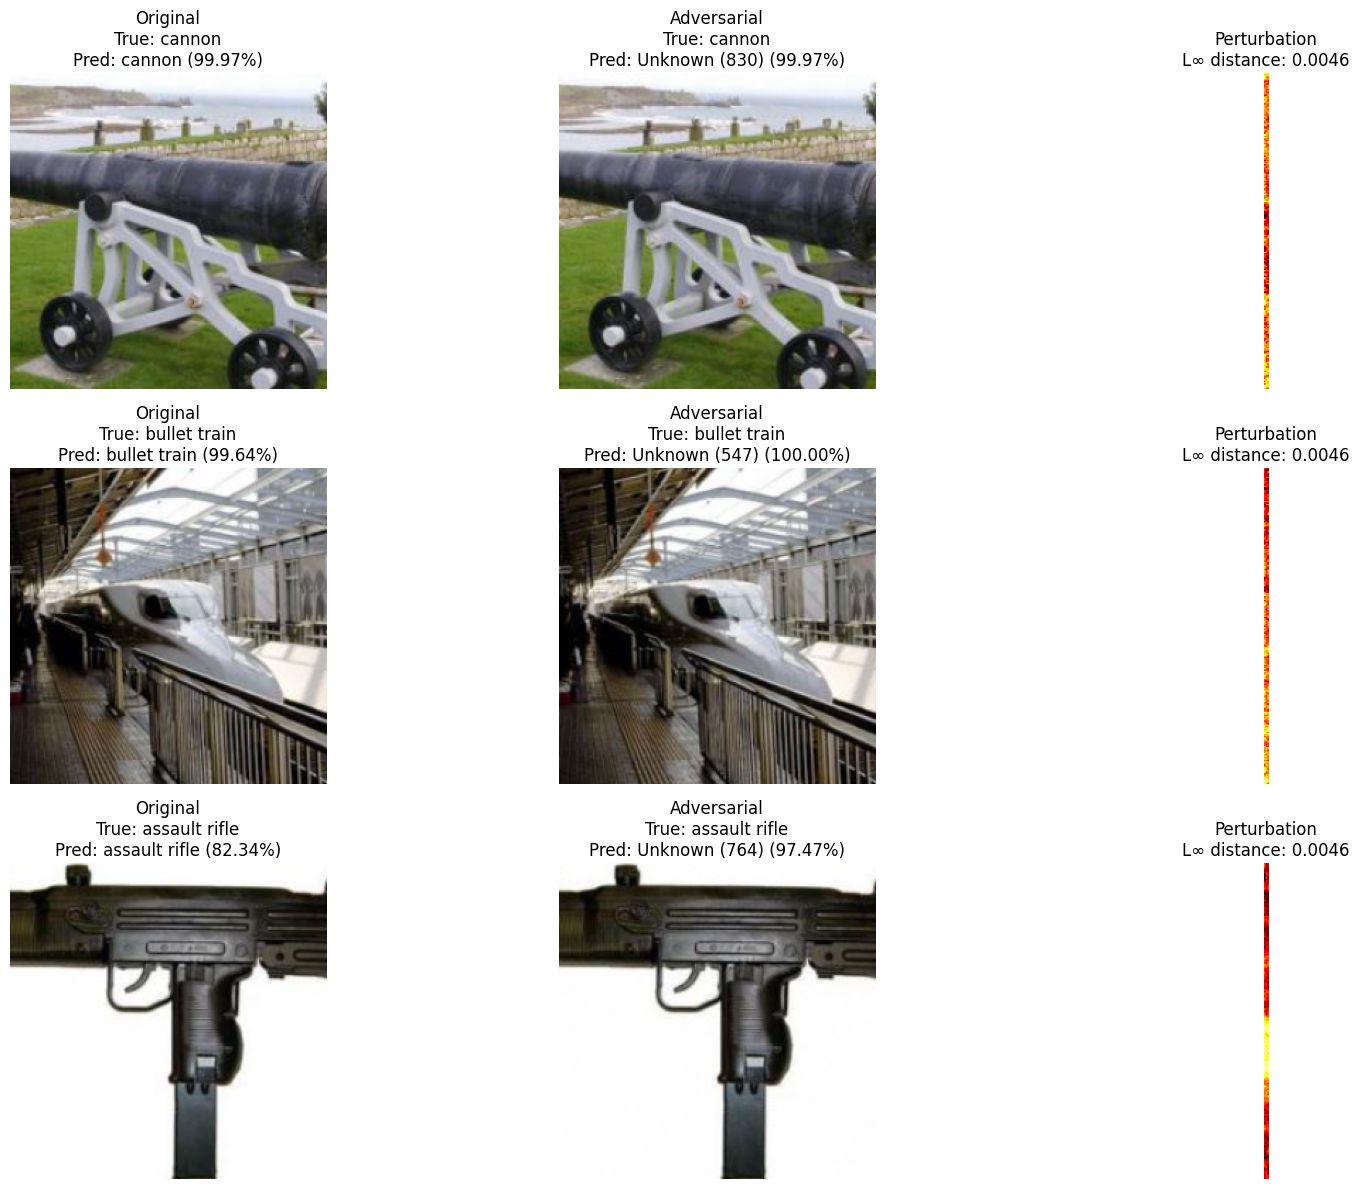


Testing Momentum PGD (10 steps) attack:


Creating adversarial examples (ε=0.02): 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Maximum raw-pixel L∞ distance: 0.004580 (should be ≤ 0.02)


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 17.57it/s]


Top-1 Accuracy: 0.20%
Top-5 Accuracy: 7.60%
Total samples evaluated: 500
Top-1 accuracy drop: 70.20% (from 70.40% to 0.20%)
Top-5 accuracy drop: 85.60% (from 93.20% to 7.60%)

Visualizing Momentum PGD (10 steps) examples:


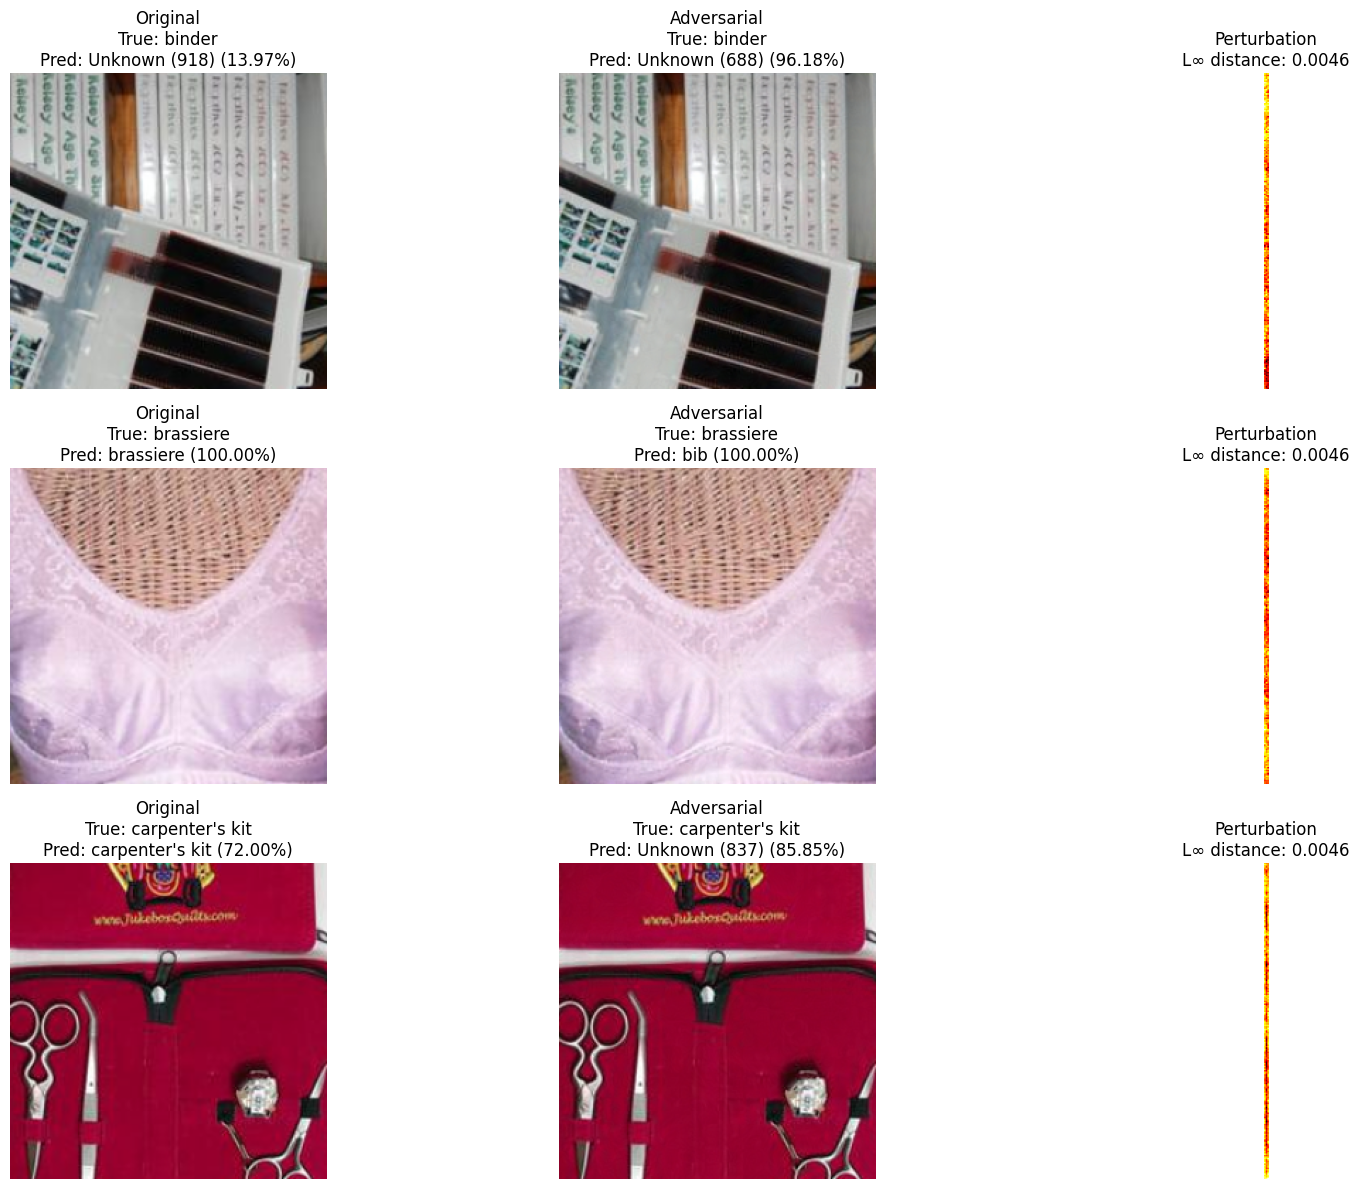


Testing Targeted PGD (10 steps) attack:


Creating adversarial examples (ε=0.02): 100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Maximum raw-pixel L∞ distance: 0.004580 (should be ≤ 0.02)


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 17.00it/s]


Top-1 Accuracy: 12.00%
Top-5 Accuracy: 26.80%
Total samples evaluated: 500
Top-1 accuracy drop: 58.40% (from 70.40% to 12.00%)
Top-5 accuracy drop: 66.40% (from 93.20% to 26.80%)

Visualizing Targeted PGD (10 steps) examples:


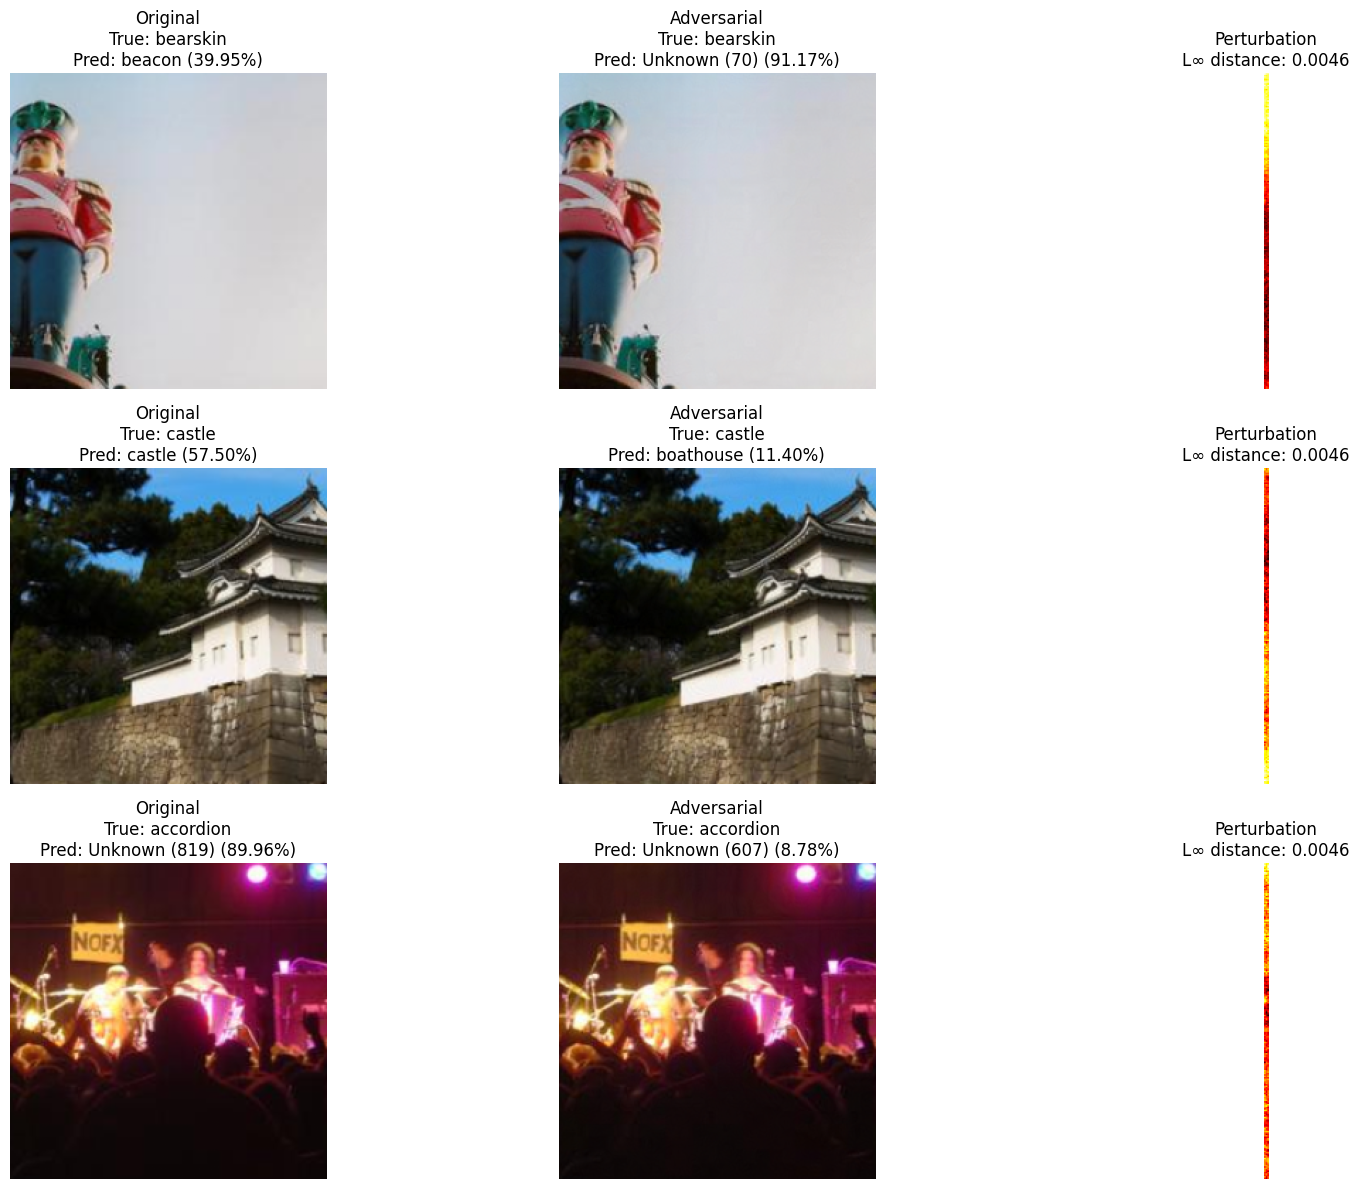


Best attack method: PGD (10 steps)
Top-1 accuracy drop: 70.40%
Top-5 accuracy drop: 85.20%
 Adversarial dataset saved to: /kaggle/working/adversarial_test_set_2.pt
Saved best attack results as 'adversarial_test_set_2.pt'
Best attack strategy: PGD-10
Top-1 accuracy drop: 70.40%


In [91]:
# === Execute Task 3: Evaluate Multiple Adversarial Attacks ===
results, best_attack = execute_task_3(
    model=model,             # Pretrained ResNet‑34 model
    dataloader=loader,       # DataLoader for the clean test set
    dataset=ds,              # The corresponding ImageFolder dataset
    class_names=cls_names,   # Dictionary mapping class indices to human-readable labels
    mean_norms=mean,         # Normalization means (e.g., [0.485, 0.456, 0.406])
    std_norms=std,           # Normalization stds (e.g., [0.229, 0.224, 0.225])
    epsilon=0.02,            # Perturbation budget (L∞ constraint)
    device=device            # Device to run attacks on ('cuda' or 'cpu')
)

# === Report Most Effective Attack ===
print(f"Best attack strategy: {best_attack}")
print(f"Top-1 accuracy drop: {results[best_attack]['top1_drop']:.2f}%")


In [92]:
# ----- TASK 4: PATCH ATTACKS -----

def patch_pgd_attack(model,
                     images,
                     labels,
                     epsilon=0.3,
                     alpha=0.05,
                     num_iter=20,
                     patch_size=32,
                     device='cuda'):
    """
    Performs a localized PGD attack on a square patch region of each image.

    Instead of applying perturbations across the entire image, this attack perturbs
    only a randomly chosen square patch (patch_size × patch_size) per image, bounded by L∞ norm.

    Args:
        model (nn.Module): The model to attack.
        images (Tensor): Input images (normalized), shape [B, C, H, W].
        labels (Tensor): Corresponding labels.
        epsilon (float): Max L∞ perturbation magnitude.
        alpha (float): Step size per iteration.
        num_iter (int): Number of attack steps.
        patch_size (int): Size of square patch to perturb.
        device (str): Computation device ('cuda' or 'cpu').

    Returns:
        Tensor: Adversarial images with localized perturbations.
    """
    # Move inputs to device
    images = images.to(device)
    labels = labels.to(device)
    batch_size, _, height, width = images.shape

    # Initialize perturbation (delta) with zeros; only patch will be updated
    delta = torch.zeros_like(images)

    # Randomly select patch top-left corner per image
    top = torch.randint(0, height - patch_size + 1, (batch_size,), device=device)
    left = torch.randint(0, width - patch_size + 1, (batch_size,), device=device)

    for _ in range(num_iter):
        # Enable gradient tracking for the perturbation
        delta.requires_grad_(True)

        # Forward pass with perturbed images
        logits = model(images + delta)
        loss = torch.nn.functional.cross_entropy(logits, labels)

        # Compute gradient of loss w.r.t. delta
        model.zero_grad()
        loss.backward()
        grad = delta.grad.detach()

        # Update delta only inside the selected patch (per image)
        with torch.no_grad():
            for i in range(batch_size):
                t, l = top[i].item(), left[i].item()
                patch_grad = grad[i, :, t:t+patch_size, l:l+patch_size]
                delta[i, :, t:t+patch_size, l:l+patch_size] += alpha * patch_grad.sign()

            # Clip delta to satisfy Linf constraint
            delta = torch.clamp(delta, min=-epsilon, max=epsilon)

            # Ensure resulting images are in valid range
            delta = torch.clamp(images + delta, min=IM_LOW, max=IM_HIGH) - images

        # Detach for next iteration
        delta = delta.detach()

    return (images + delta).detach()


In [93]:
def create_patch_adversarial_dataset(model,
                                     original_images,
                                     original_labels,
                                     attack_fn,
                                     epsilon=0.3,
                                     batch_size=32,
                                     device='cuda',
                                     **attack_kwargs):
    """
    Generates adversarial examples using a localized (patch-based) attack across the full dataset.

    This is a wrapper around a patch-specific attack function (e.g., patch_pgd_attack),
    which applies the attack in mini-batches to handle memory constraints.

    Args:
        model (nn.Module): Model to be attacked.
        original_images (Tensor): Clean input images.
        original_labels (Tensor): Corresponding ground-truth labels.
        attack_fn (callable): Patch attack function to apply (must accept batching).
        epsilon (float): L∞ constraint for perturbations.
        batch_size (int): Number of images per mini-batch.
        device (str): Computation device ('cuda' or 'cpu').
        **attack_kwargs: Additional arguments to pass to the attack function.

    Returns:
        Tensor: Full set of patch-perturbed adversarial images.
    """
    adv_images = []
    total_samples = len(original_images)
    num_batches = (total_samples + batch_size - 1) // batch_size  # Ceiling division

    for i in tqdm(range(num_batches), desc=f"Patch attack (ε={epsilon})"):
        # Extract current mini-batch
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)
        batch_images = original_images[start_idx:end_idx]
        batch_labels = original_labels[start_idx:end_idx]

        # Generate adversarial images using the patch attack
        adv_batch = attack_fn(
            model=model,
            images=batch_images,
            labels=batch_labels,
            epsilon=epsilon,
            device=device,
            **attack_kwargs
        )

        # Detach and move to CPU
        adv_images.append(adv_batch.cpu().float())

    return torch.cat(adv_images, dim=0)


In [94]:
def execute_task_4(model,
                   all_images,
                   all_labels,
                   class_names,
                   mean,
                   std,
                   device='cuda'):
    """
    Executes Task 4: Applies a localized patch-based PGD attack to generate adversarial examples,
    evaluates model performance, visualizes results, and saves the adversarial dataset.

    This attack perturbs only a square patch in each image, making it harder to detect
    while still affecting model predictions.

    Args:
        model (nn.Module): Pretrained ResNet-34 model.
        all_images (Tensor): Clean input images.
        all_labels (Tensor): Ground-truth labels.
        class_names (dict): Mapping from label index to class name.
        mean (list): Normalization means used during preprocessing.
        std (list): Normalization stds used during preprocessing.
        device (str): Device to run the attack on.

    Returns:
        Tensor: Adversarial images generated from the patch attack.
    """
    print("\n=== Task 4: Patch Attacks ===")

    # Define attack strength and patch size
    epsilon = 0.5           # Larger budget than typical full-image attacks
    patch_size = 32         # Localized square patch

    # Step 1: Generate adversarial examples using patch-based PGD
    adv3 = create_patch_adversarial_dataset(
        model=model,
        original_images=all_images,
        original_labels=all_labels,
        attack_fn=patch_pgd_attack,
        epsilon=epsilon,
        batch_size=32,
        device=device,
        alpha=epsilon / 5,
        num_iter=20,
        patch_size=patch_size
    )

    # Step 2: Validate perturbation bound (L∞ constraint)
    l_inf = compute_l_inf_distance(all_images, adv3).max().item()
    print(f"Max L∞ on patch attack: {l_inf:.4f} (should ≤ {epsilon})")

    # Step 3: Evaluate model on the adversarial dataset
    adv_dataset = torch.utils.data.TensorDataset(adv3, all_labels)
    adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=32, shuffle=False)
    top1_acc, top5_acc, _, _ = evaluate_model(model, adv_loader, device=device)
    print(f"Patch Attack Top-1: {top1_acc:.2f}%, Top-5: {top5_acc:.2f}%")

    # Step 4: Visualize some examples
    visualize_adversarial_examples(
        model=model,
        original_images=all_images,
        adversarial_images=adv3,
        original_labels=all_labels,
        class_names=class_names,
        mean_norms=mean,
        std_norms=std,
        num_samples=5
    )

    # Step 5: Save adversarial dataset to disk
    save_adversarial_dataset(
        adversarial_images=adv3,
        dataset_path="/kaggle/working",
        filename="adversarial_test_set_3.pt"
    )

    return adv3


In [95]:
# ----- TASK 5: TRANSFERRING ATTACKS -----

def execute_task_5(original_images,
                   all_labels,
                   adv1,
                   adv2,
                   adv3,
                   class_names,
                   device='cuda'):
    """
    Evaluates the transferability of adversarial examples to a different model architecture.

    This task checks whether adversarial examples (e.g., FGSM, PGD, Patch) generated
    on one model (e.g., ResNet-34) are effective against another model (e.g., DenseNet-121).

    Args:
        original_images (Tensor): Clean input images.
        all_labels (Tensor): Corresponding ground-truth labels.
        adv1 (Tensor): FGSM adversarial images.
        adv2 (Tensor): Strongest adversarial set from Task 3.
        adv3 (Tensor): Patch-based adversarial images.
        class_names (dict): Mapping from label index to class name (not used here but passed for compatibility).
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        dict: Mapping from dataset name to (Top-1, Top-5) accuracy on the transfer model.
    """
    print("\n=== Task 5: Transferability ===")

    # Step 1: Load a different architecture for transferability test
    print("Loading alternate model: DenseNet-121 (ImageNet pretrained)")
    new_model = torchvision.models.densenet121(weights="IMAGENET1K_V1").to(device).eval()

    # Step 2: Prepare datasets to evaluate
    attack_sets = {
        "Original": original_images,
        "FGSM":     adv1,
        "Best-Adv": adv2,
        "Patch":    adv3
    }

    # Step 3: Evaluate on each adversarial dataset
    results = {}
    for name, images in attack_sets.items():
        dataset = torch.utils.data.TensorDataset(images, all_labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

        top1, top5, _, _ = evaluate_model(new_model, dataloader, device=device)
        results[name] = (top1, top5)

        print(f"{name:>8}: Top-1 = {top1:.2f}%, Top-5 = {top5:.2f}%")

    # Step 4: Summarize results in a clean format
    print("\nSummary of Transfer Results:")
    for name, (top1, top5) in results.items():
        print(f"  {name:>8} → Top-1: {top1:.1f}%, Top-5: {top5:.1f}%")

    return results



=== Task 4: Patch Attacks ===


Patch attack (ε=0.5): 100%|██████████| 16/16 [00:50<00:00,  3.18s/it]


Max L∞ on patch attack: 0.5000 (should ≤ 0.5)


Evaluating model: 100%|██████████| 16/16 [00:00<00:00, 17.53it/s]


Top-1 Accuracy: 26.00%
Top-5 Accuracy: 64.60%
Total samples evaluated: 500
Patch Attack Top-1: 26.00%, Top-5: 64.60%


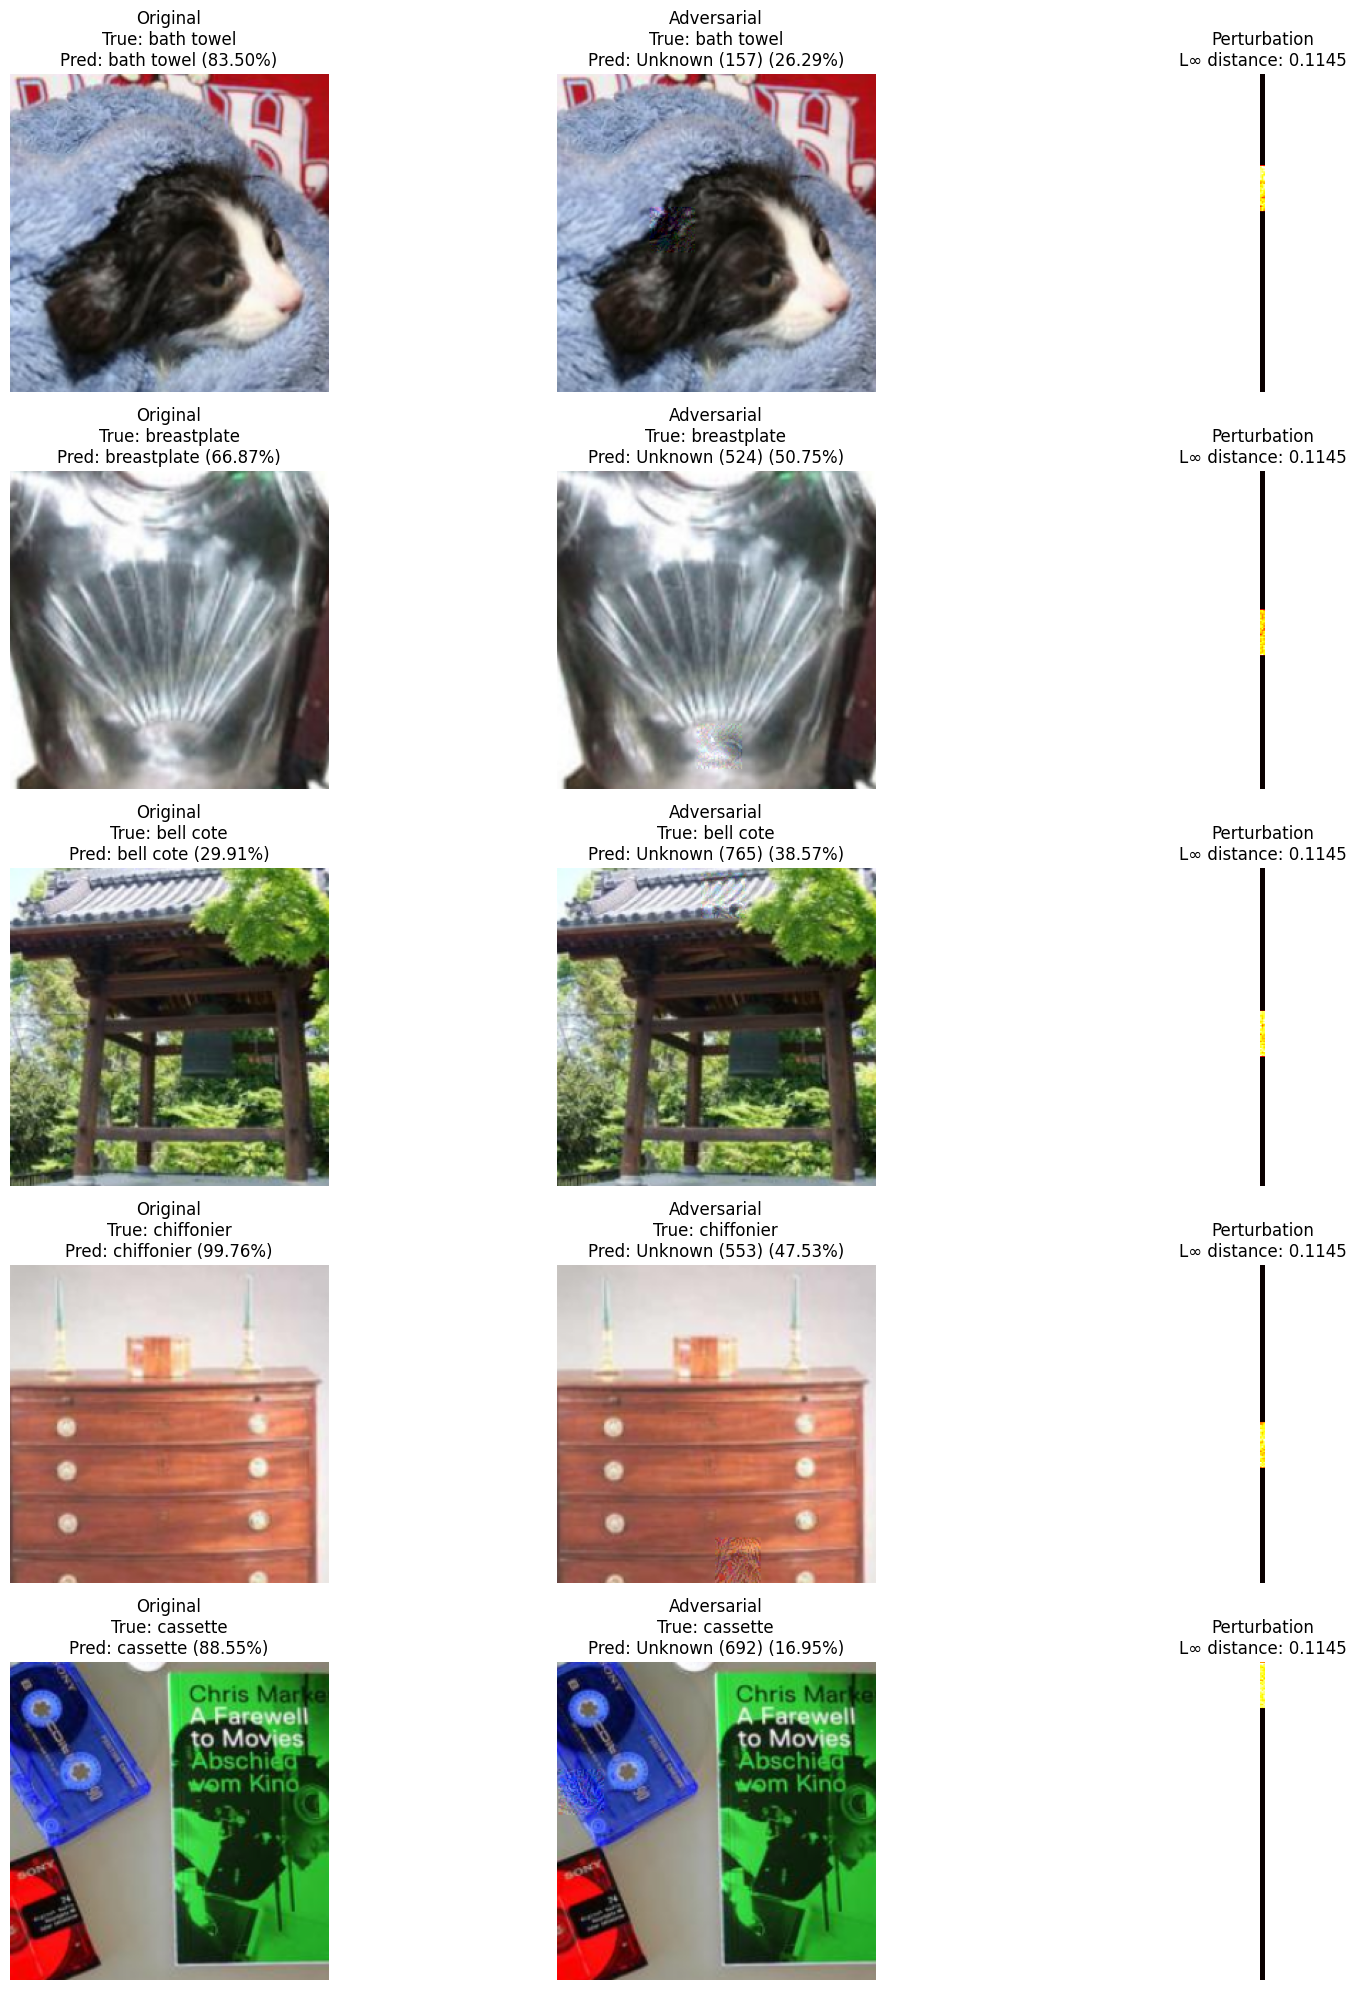

 Adversarial dataset saved to: /kaggle/working/adversarial_test_set_3.pt


In [96]:
# Task 4
adv3 = execute_task_4(model, all_images, all_labels, cls_names, mean, std, device=device)

In [97]:
adv2 = results[best_attack]["images"]

In [98]:
# Task 5
trans_results = execute_task_5(
    all_images,
    all_labels,
    adv1,      # your FGSM set
    adv2,      # your best improved‐attack set
    adv3,      # your patch‐attack set
    cls_names,
    device=device
)


=== Task 5: Transferability ===
Loading alternate model: DenseNet-121 (ImageNet pretrained)


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  9.18it/s]


Top-1 Accuracy: 70.80%
Top-5 Accuracy: 91.20%
Total samples evaluated: 500
Original: Top-1 = 70.80%, Top-5 = 91.20%


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  9.32it/s]


Top-1 Accuracy: 40.00%
Top-5 Accuracy: 69.40%
Total samples evaluated: 500
    FGSM: Top-1 = 40.00%, Top-5 = 69.40%


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  9.33it/s]


Top-1 Accuracy: 58.20%
Top-5 Accuracy: 86.80%
Total samples evaluated: 500
Best-Adv: Top-1 = 58.20%, Top-5 = 86.80%


Evaluating model: 100%|██████████| 16/16 [00:01<00:00,  9.26it/s]


Top-1 Accuracy: 66.40%
Top-5 Accuracy: 88.00%
Total samples evaluated: 500
   Patch: Top-1 = 66.40%, Top-5 = 88.00%

Summary of Transfer Results:
  Original → Top-1: 70.8%, Top-5: 91.2%
      FGSM → Top-1: 40.0%, Top-5: 69.4%
  Best-Adv → Top-1: 58.2%, Top-5: 86.8%
     Patch → Top-1: 66.4%, Top-5: 88.0%


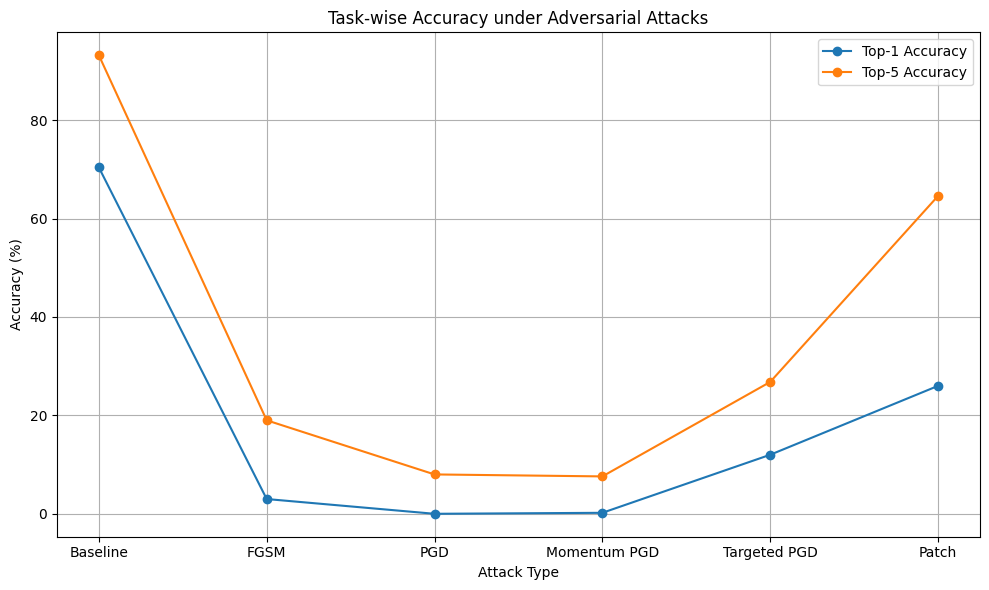

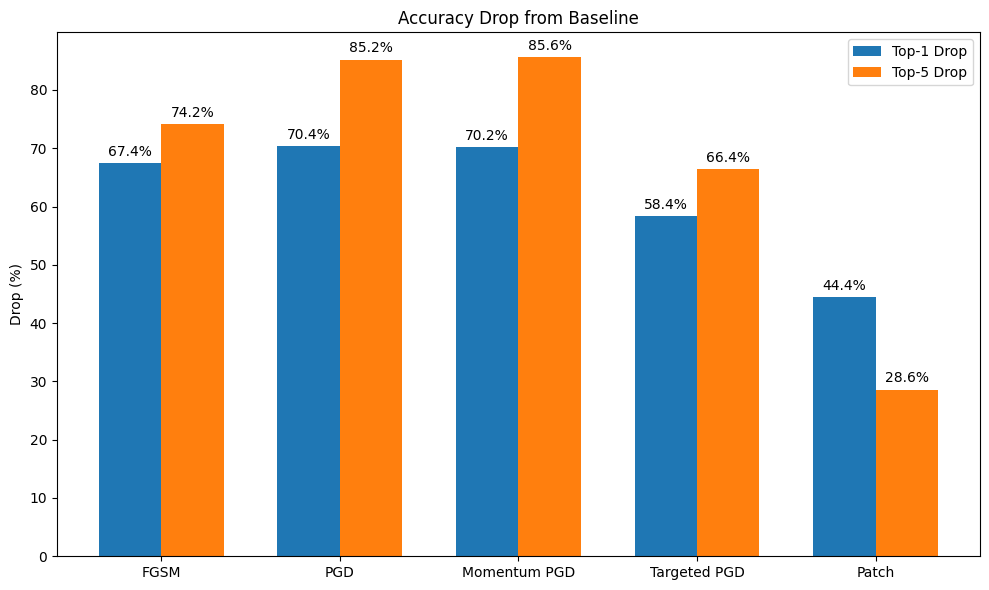

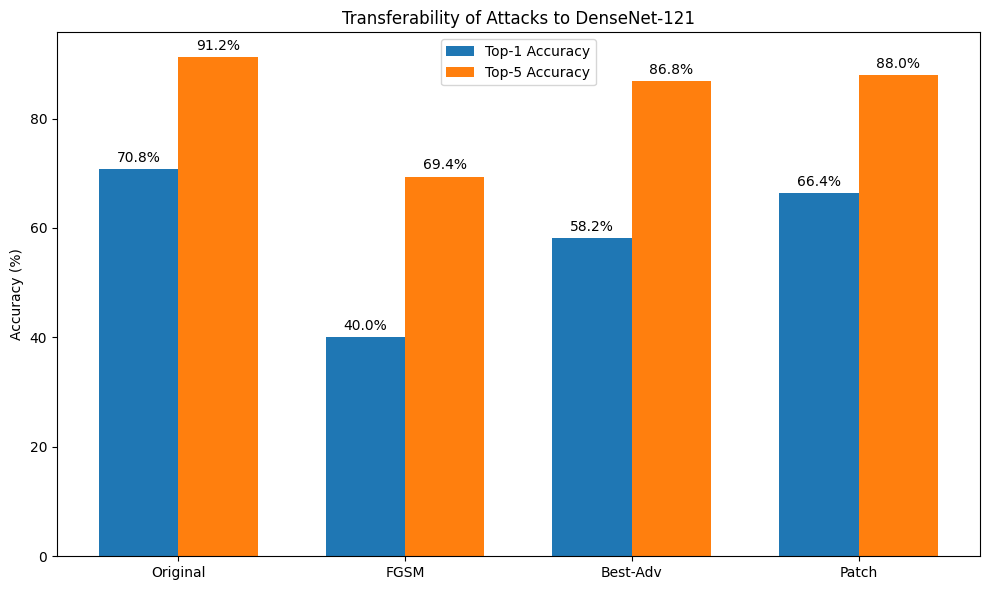

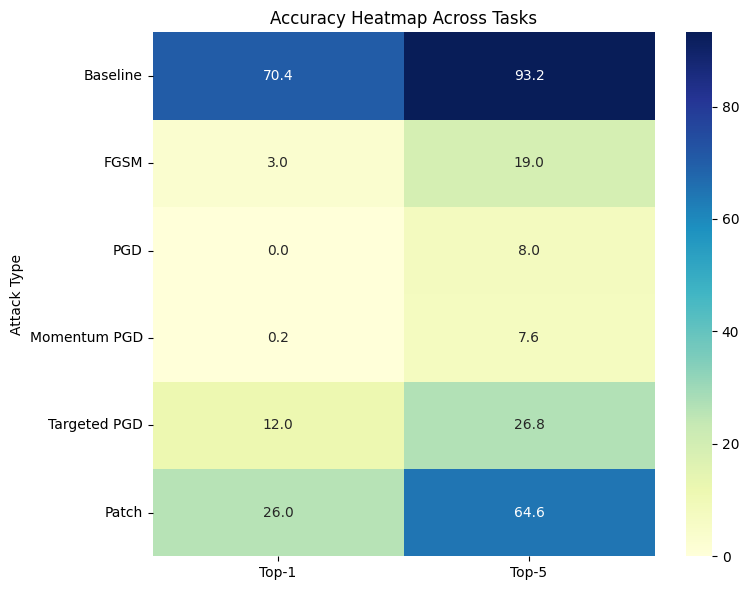

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------- DATA ------------
tasks = ['Baseline', 'FGSM', 'PGD', 'Momentum PGD', 'Targeted PGD', 'Patch']
top1 = [70.4, 3.0, 0.0, 0.2, 12.0, 26.0]
top5 = [93.2, 19.0, 8.0, 7.6, 26.8, 64.6]

# ----------- LINE PLOT (Accuracy per Task) ------------
plt.figure(figsize=(10, 6))
plt.plot(tasks, top1, marker='o', label='Top-1 Accuracy')
plt.plot(tasks, top5, marker='o', label='Top-5 Accuracy')
plt.title('Task-wise Accuracy under Adversarial Attacks')
plt.ylabel('Accuracy (%)')
plt.xlabel('Attack Type')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_per_task.png')
plt.show()

# ----------- BAR PLOT (Accuracy Drop) ------------
baseline_top1 = 70.4
baseline_top5 = 93.2
attacks = tasks[1:]

drop_top1 = [baseline_top1 - acc for acc in top1[1:]]
drop_top5 = [baseline_top5 - acc for acc in top5[1:]]

x = np.arange(len(attacks))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, drop_top1, width, label='Top-1 Drop')
bars2 = plt.bar(x + width/2, drop_top5, width, label='Top-5 Drop')
plt.xticks(x, attacks)
plt.ylabel('Drop (%)')
plt.title('Accuracy Drop from Baseline')
plt.legend()

# Add labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('accuracy_drop_barplot.png')
plt.show()

# ----------- GROUPED BAR PLOT (Transferability) ------------
transfer_tasks = ['Original', 'FGSM', 'Best-Adv', 'Patch']
transfer_top1 = [70.8, 40.0, 58.2, 66.4]
transfer_top5 = [91.2, 69.4, 86.8, 88.0]

x = np.arange(len(transfer_tasks))
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, transfer_top1, width, label='Top-1 Accuracy')
bars2 = plt.bar(x + width/2, transfer_top5, width, label='Top-5 Accuracy')
plt.xticks(x, transfer_tasks)
plt.ylabel('Accuracy (%)')
plt.title('Transferability of Attacks to DenseNet-121')
plt.legend()

# Add labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('transferability_results.png')
plt.show()

# ----------- HEATMAP (Optional Summary View) ------------
import pandas as pd

df_heat = pd.DataFrame({
    'Top-1': top1,
    'Top-5': top5
}, index=tasks)

plt.figure(figsize=(8, 6))
sns.heatmap(df_heat, annot=True, fmt='.1f', cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap Across Tasks')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.savefig('accuracy_heatmap.png')
plt.show()


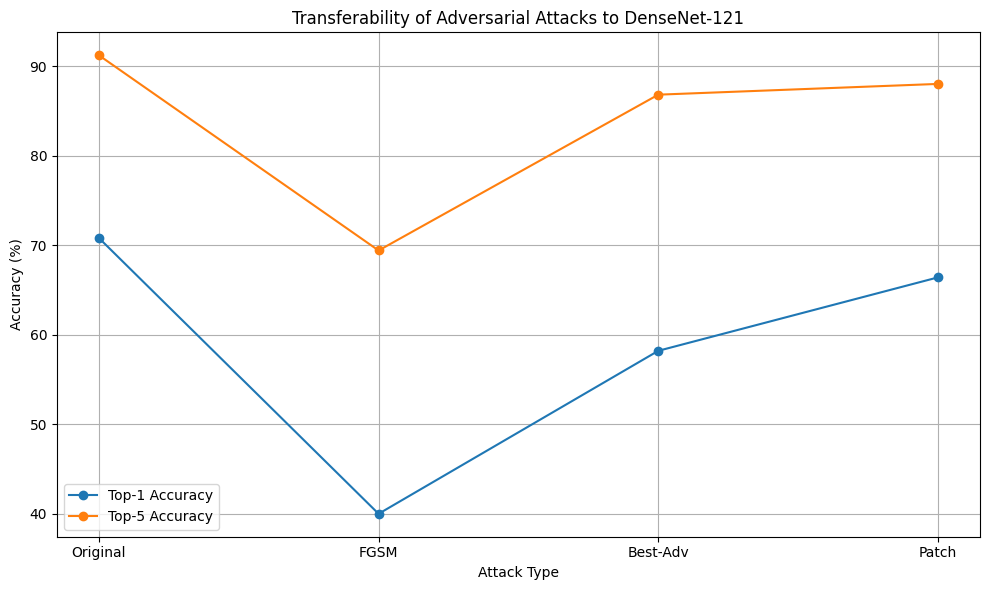

In [116]:
import matplotlib.pyplot as plt

# Transferability data
transfer_tasks = ['Original', 'FGSM', 'Best-Adv', 'Patch']
transfer_top1 = [70.8, 40.0, 58.2, 66.4]
transfer_top5 = [91.2, 69.4, 86.8, 88.0]

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(transfer_tasks, transfer_top1, marker='o', label='Top-1 Accuracy')
plt.plot(transfer_tasks, transfer_top5, marker='o', label='Top-5 Accuracy')

# Labels and styling
plt.title('Transferability of Adversarial Attacks to DenseNet-121')
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('transferability_line_plot.png')
plt.show()
